In [1]:
#Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd;
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
import os
import sys
import shutil
import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from spektral.data.utils import to_tf_signature, prepend_none
from spektral.data import DisjointLoader, Dataset
from spektral.transforms import GCNFilter, NormalizeAdj
from spektral.layers import GlobalMaxPool, GlobalAvgPool, GCSConv
import scipy.sparse
from spektral.data.graph import Graph
from keras.layers import Dense, concatenate, Dropout, Concatenate
from keras import Model

In [2]:
features = pd.read_csv('thingi10k_data.csv', index_col=0)
adjpath = '../Data/stl/adjacency_stl_simplified/'
cloudpath = '../Data/stl/nodefeatures_stl_simplified/'
edgepath = '../Data/stl/edgefeaturesmatrix_stl_simplified/'

In [3]:
#Custom disjointloader
def getFeatures(batch):
    feats = []
    for graph in batch:
        feats.append(graph.__getattribute__('feats'))
    return np.array(feats)

class MyDisjointLoader(DisjointLoader):
    def __init__(
        self, dataset, node_level=False, batch_size=1, epochs=None, shuffle=True
    ):
        self.node_level = node_level
        super().__init__(dataset, batch_size=batch_size, epochs=epochs, shuffle=shuffle)

    def __next__(self):
        nxt = self._generator.__next__()
        feats = getFeatures(nxt)
        #feats = nxt[0].__getattribute__('feats')
        output, y = self.collate(nxt)
        feats = (feats,)
        output = output + feats
        return   output, y
    
    def tf_signature(self):
    
        signature = self.dataset.signature
        if "y" in signature:
            signature["y"]["shape"] = prepend_none(signature["y"]["shape"])
        if "a" in signature:
            signature["a"]["spec"] = tf.SparseTensorSpec

        signature["i"] = dict()
        signature["i"]["spec"] = tf.TensorSpec
        signature["i"]["shape"] = (None,)
        signature["i"]["dtype"] = tf.as_dtype(tf.int64)

        sig = (tf.TensorSpec(shape=[None,12]),)
        input = to_tf_signature(signature)
        sig = input[0] + sig
        return (sig, input[1])

In [4]:
#Read data, drop unnecessary
data = pd.read_csv('thingi10k_data.csv', index_col=0)

df = data.copy()
df.drop("source", axis=1, inplace=True)
df.drop("model_name", axis=1, inplace=True)
df.drop("support_material", axis=1, inplace=True)

#Extract build times
build_times = df["build_time"]
df.drop("build_time", axis=1,inplace=True)

#Make pipeline
def log_transform(x):
    return np.log(x + 1)

def inv_log_transform(x):
    return np.exp(x) - 1 

logtransformer = FunctionTransformer(func=log_transform, inverse_func=inv_log_transform, check_inverse=False)
pipe = Pipeline(steps=[ ('logtransformer', logtransformer)])

#Log transform
transformed = pipe.fit_transform(df)
df = np.asarray(transformed)
build_times = np.asarray(build_times)

In [5]:
#Graph dataset
class MyDataset(Dataset):
    def __init__(self, centroids, dev, index, **kwargs):
        self.centroids = centroids
        self.dev = dev
        self.index = index
        super().__init__(**kwargs)

    def read(self):
        output = []
        for i in self.index:
            if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
                point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
                edgefeat = scipy.sparse.load_npz(edgepath + f'{features["model_name"][i]}.npz')
                output.append(
                    Graph(x=((point_cloud-self.centroids)/self.dev), a=edgefeat, y=features["build_time"][i], feats=df[i])
                )
            else:
                print(f'object {i} missing!')

        return output

In [6]:
def get_split_graphs(trainindex, testindex):
    print("Getting split...")
    coords = np.empty((1,3))

    for i in trainindex:
        if(os.path.isfile(adjpath + f'{features["model_name"][i]}.npz')):
            point_cloud = np.load(cloudpath + f'{features["model_name"][i]}.npy').reshape(-1,3)
            coords = np.concatenate((coords,point_cloud))
            

    coords = np.delete(coords,0,0)
    centroids = np.mean(coords,0)
    coordscentered = coords - centroids
    dev = np.max(np.sqrt(np.sum(coordscentered**2,axis=-1) / (trainindex.shape[0] - 1)))

    train = MyDataset(centroids, dev, trainindex)
    test = MyDataset(centroids, dev, testindex)
    validation = MyDataset(centroids, dev, range(3478,3661))
    train.apply(NormalizeAdj())
    test.apply(NormalizeAdj())
    validation.apply(NormalizeAdj())
    train = MyDisjointLoader(train, batch_size=32)
    test = MyDisjointLoader(test, batch_size=32)
    validation = MyDisjointLoader(validation, batch_size=32)
    
    return train, test, validation

    

In [7]:
#Define callbacks
def get_callbacks(weights_file, patience, lr_factor):
  return [
      # Only save the weights that correspond to the minimum mape.
      ModelCheckpoint(filepath= weights_file,
                      monitor="val_mape", 
                      mode="min",
                      save_best_only=True, 
                      save_weights_only=False),
      # If val_loss doesn't improve for a number of epochs set with 'patience' var 
      # training will stop to avoid overfitting.    
      EarlyStopping(monitor="val_loss",
                    mode="min",
                    patience = patience,
                    verbose=1),
      # Learning rate is reduced by 'lr_factor' if val_loss stagnates
      # for a number of epochs set with 'patience/2' var.     
      ReduceLROnPlateau(monitor="val_loss", mode="min",
                        factor=lr_factor, min_lr=1e-8, patience=patience//2, verbose=1)]

In [8]:
#util
def reset_model(model):
    import keras.backend as K
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel.initializer') and layer.trainable: 
            layer.kernel.initializer.run(session=session)
        if hasattr(layer, 'bias.initializer') and layer.trainable:
            layer.bias.initializer.run(session=session)

def make_trainable(model):
    for layer in model.layers:
        layer.trainable = True

In [9]:
#Validation
def cross_validate(model, dir):
    loss_per_fold = []
    mae_per_fold = []
    mape_per_fold = []
    validation_per_fold = []
    batch_size = 32
    verbosity = 1
    no_epochs = 1000
    kfold = KFold(n_splits=5, shuffle=True)
    basemodel = model

    if len(model.inputs) == 1:
        print('Baselinemodel')

        fold_no = 1
        for train, test in kfold.split(df[0:3478], build_times[0:3478]):

            reset_model(model)

            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            model.compile(loss='mape',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae','mape']
            )

            history = model.fit(df[train], build_times[train], validation_data=(df[test], build_times[test]),
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=get_callbacks(f'{dir}_{fold_no}',
                                            patience=60,
                                            lr_factor=0.3))
            model = keras.models.load_model(f"{dir}_{fold_no}")

            # Generate generalization metrics
            valscores = model.evaluate(df[3478:3661], build_times[3478:3661], batch_size=32, verbose=0)
            validation_per_fold.append(valscores)
            scores = model.evaluate(df[test], build_times[test], verbose=0)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}%;')
            loss_per_fold.append(scores[0])
            mae_per_fold.append(scores[1])
            mape_per_fold.append(scores[2])

            # Increase fold number
            fold_no = fold_no + 1
    else:
        print('multi-input')
        fold_no = 1
        for train, test in kfold.split(df[0:3478], build_times[0:3478]):

            reset_model(model) #wegcommenten voor additional training
            #model = basemodel
            #model = keras.models.load_model("crossvalidationmodels/Hybrid_nosupp_freeze_4/")
            #make_trainable(model)

            trainloader, testloader, validationloader = get_split_graphs(train, test)

            print('------------------------------------------------------------------------')
            print(f'Training for fold {fold_no} ...')

            model.compile(loss='mape',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #0.001
                metrics=['mae','mape']
            )
            history = model.fit(trainloader.load(), validation_data=testloader.load(), validation_steps=testloader.steps_per_epoch, steps_per_epoch=trainloader.steps_per_epoch,
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity,
              callbacks=get_callbacks(f'{dir}_{fold_no}',
                                            patience=60,
                                            lr_factor=0.3))
            model = keras.models.load_model(f"{dir}_{fold_no}")
        
            # Generate generalization metrics
            valscores = model.evaluate(validationloader.load(), steps=validationloader.steps_per_epoch, batch_size=32, verbose=0)
            validation_per_fold.append(valscores)
            scores = model.evaluate(testloader.load(), steps=testloader.steps_per_epoch, batch_size=32, verbose=0)
            print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}; {model.metrics_names[2]} of {scores[2]}%;')
            loss_per_fold.append(scores[0])
            mae_per_fold.append(scores[1])
            mape_per_fold.append(scores[2])

            # Increase fold number
            fold_no = fold_no + 1
    return loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold

    

In [10]:
#Print scores
def print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold):
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(loss_per_fold)):
        print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Mean average error: {mae_per_fold[i]}% - Mean percentage error: {mape_per_fold[i]}%')
        print(f'    Score on unseen data: Loss: {validation_per_fold[i][0]} - Mean average error: {validation_per_fold[i][1]}% - Mean percentage error: {validation_per_fold[i][2]}%')
        print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> Mean average error: {np.mean(mae_per_fold)}')
    print(f'> Mean percentage error: {np.mean(mape_per_fold)}')
    print(f'> Unseen Loss: {np.mean(np.asarray(validation_per_fold)[:,0])}')
    print(f'> Unseen Mean average error: {np.mean(np.asarray(validation_per_fold)[:,1])}')
    print(f'> Unseen Mean percentage error: {np.mean(np.asarray(validation_per_fold)[:,2])}')
    print('------------------------------------------------------------------------')
    

In [12]:
nnmodel = keras.models.load_model('savedmodels/Baseline_nosupp_final')

xi = keras.layers.Input( name= 'Input_x', type_spec=tf.TensorSpec(shape=[None,3]))
ai = keras.layers.Input( name= 'Input_a', type_spec=tf.SparseTensorSpec(shape=[None,None]))
ii = keras.layers.Input( name= 'Input_i', type_spec=tf.TensorSpec(shape=[None,], dtype='int32'))

x1 = GCSConv(64, 'relu')([xi,ai]) 
x2 = GCSConv(128, 'relu')([x1,ai])
x = Concatenate()([x1,x2])
x= GlobalMaxPool()([x,ii])


combined = concatenate([nnmodel.get_layer('dropbaseline').output, x], name='join')
z = Dense(128,'relu', name='dense1')(combined)
z = Dense(64,'relu', name='dense4')(z)
z = Dropout(0.2, name='finaldrop')(z)
z = Dense(1, 'linear', name='Output')(z)

model = Model(inputs=[xi,ai,ii,nnmodel.input], outputs=z)
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, "crossvalidationmodels/Hybrid_short")

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 35.9018 - mae: 85.6307 - mape: 35.9018

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 11s 95ms/step - loss: 35.9018 - mae: 85.6307 - mape: 35.9018 - val_loss: 21.8615 - val_mae: 38.8569 - val_mape: 21.8615 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 22.4467 - mae: 52.4783 - mape: 22.4467

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 8s 95ms/step - loss: 22.4467 - mae: 52.4783 - mape: 22.4467 - val_loss: 17.4268 - val_mae: 37.2727 - val_mape: 17.4268 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 21.2655 - mae: 48.6465 - mape: 21.2655

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 8s 95ms/step - loss: 21.2655 - mae: 48.6465 - mape: 21.2655 - val_loss: 17.3372 - val_mae: 34.5460 - val_mape: 17.3372 - lr: 0.0010
Epoch 4/1000
 1/87 [..............................] - ETA: 5s - loss: 18.0169 - mae: 52.2808 - mape: 18.0169

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 18.9574 - mae: 44.1017 - mape: 18.9574 - val_loss: 19.9149 - val_mae: 31.4315 - val_mape: 19.9149 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 77ms/step - loss: 19.0000 - mae: 51.3099 - mape: 19.0000 - val_loss: 20.8099 - val_mae: 27.5746 - val_mape: 20.8099 - lr: 0.0010
Epoch 6/1000
86/87 [============================>.] - ETA: 0s - loss: 18.5695 - mae: 49.8814 - mape: 18.5695

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 8s 95ms/step - loss: 18.5691 - mae: 49.5170 - mape: 18.5691 - val_loss: 17.2241 - val_mae: 32.4921 - val_mape: 17.2241 - lr: 0.0010
Epoch 7/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 18.1283 - mae: 41.3434 - mape: 18.1283

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 8s 95ms/step - loss: 18.1283 - mae: 41.3434 - mape: 18.1283 - val_loss: 15.5750 - val_mae: 29.2101 - val_mape: 15.5750 - lr: 0.0010
Epoch 8/1000
 1/87 [..............................] - ETA: 5s - loss: 16.4059 - mae: 14.3825 - mape: 16.4059

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 17.7822 - mae: 48.7166 - mape: 17.7822

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 9s 105ms/step - loss: 17.7905 - mae: 48.3051 - mape: 17.7905 - val_loss: 14.7165 - val_mae: 29.9797 - val_mape: 14.7165 - lr: 0.0010
Epoch 9/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 19.7579 - mae: 47.2650 - mape: 19.7579 - val_loss: 15.0581 - val_mae: 51.2594 - val_mape: 15.0581 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 78ms/step - loss: 18.0861 - mae: 46.2383 - mape: 18.0861 - val_loss: 14.7325 - val_mae: 41.2827 - val_mape: 14.7325 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 78ms/step - loss: 17.0553 - mae: 47.6392 - mape: 17.0553 - val_loss: 15.9126 - val_mae: 29.0301 - val_mape: 15.9126 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 7s 76ms/step - loss: 18.1610 - mae: 47.2295 - mape: 18.1610 - val_loss: 16.8503 - val_mae: 35.5594 - val_mape: 16.8503 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 77ms/step - loss: 17.7716 - mae: 44.3415 - mape: 17.7716 - val_loss: 15.8731 - val_mae: 28.8646 - val_mape: 15.8731 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 7s 77ms/step - loss: 18.

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 8s 94ms/step - loss: 16.6434 - mae: 40.3278 - mape: 16.6434 - val_loss: 14.5459 - val_mae: 31.8124 - val_mape: 14.5459 - lr: 0.0010
Epoch 24/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 81ms/step - loss: 16.8593 - mae: 41.7594 - mape: 16.8593 - val_loss: 14.7035 - val_mae: 31.7605 - val_mape: 14.7035 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.5006 - mae: 43.1145 - mape: 16.5006 - val_loss: 16.7319 - val_mae: 46.4467 - val_mape: 16.7319 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.4352 - mae: 42.9013 - mape: 16.4352 - val_loss: 19.7255 - val_mae: 54.7137 - val_mape: 19.7255 - lr: 0.0010
Epoch 27/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.6387 - mae: 49.2093 - mape: 16.6387 - val_loss: 20.7195 - val_mae: 50.1779 - val_mape: 20.7195 - lr: 0.0010
Epoch 28/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.3406 - mae: 40.0557 - mape: 16.3406 - val_loss: 14.7152 - val_mae: 32.2438 - val_mape: 14.7152 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 7s 78ms/step - loss: 17.

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_1\assets


87/87 [==============================] - 8s 93ms/step - loss: 16.6568 - mae: 40.0881 - mape: 16.6568 - val_loss: 14.2080 - val_mae: 31.4420 - val_mape: 14.2080 - lr: 0.0010
Epoch 31/1000
 1/87 [..............................] - ETA: 7s - loss: 10.9908 - mae: 36.8958 - mape: 10.9908

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\keras\saving\saved_model\layer_serialization.py:134: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)
c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 81ms/step - loss: 17.1967 - mae: 45.8654 - mape: 17.1967 - val_loss: 18.7383 - val_mae: 35.4850 - val_mape: 18.7383 - lr: 0.0010
Epoch 32/1000
87/87 [==============================] - 7s 77ms/step - loss: 17.0542 - mae: 43.8773 - mape: 17.0542 - val_loss: 16.4313 - val_mae: 35.8148 - val_mape: 16.4313 - lr: 0.0010
Epoch 33/1000
87/87 [==============================] - 7s 77ms/step - loss: 17.0832 - mae: 43.8830 - mape: 17.0832 - val_loss: 16.6707 - val_mae: 33.9232 - val_mape: 16.6707 - lr: 0.0010
Epoch 34/1000
87/87 [==============================] - 7s 77ms/step - loss: 16.1387 - mae: 41.6342 - mape: 16.1387 - val_loss: 22.3254 - val_mae: 61.2144 - val_mape: 22.3254 - lr: 0.0010
Epoch 35/1000
87/87 [==============================] - 7s 79ms/step - loss: 17.1953 - mae: 42.9534 - mape: 17.1953 - val_loss: 16.8630 - val_mae: 47.0273 - val_mape: 16.8630 - lr: 0.0010
Epoch 36/1000
87/87 [==============================] - 7s 77ms/step - loss: 15.

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 14.207966804504395; mae of 31.442018508911133; mape of 14.207966804504395%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 18.1505 - mae: 46.1707 - mape: 18.1505

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_2\assets


87/87 [==============================] - 9s 92ms/step - loss: 18.1505 - mae: 46.1707 - mape: 18.1505 - val_loss: 12.4407 - val_mae: 43.8793 - val_mape: 12.4407 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 17.4831 - mae: 47.0653 - mape: 17.4831 - val_loss: 25.7698 - val_mae: 95.6462 - val_mape: 25.7698 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 76ms/step - loss: 17.1365 - mae: 42.8774 - mape: 17.1365 - val_loss: 14.9349 - val_mae: 58.9203 - val_mape: 14.9349 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 77ms/step - loss: 16.8712 - mae: 41.7425 - mape: 16.8712 - val_loss: 15.2112 - val_mae: 75.5485 - val_mape: 15.2112 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.7505 - mae: 42.2343 - mape: 16.7505 - val_loss: 18.7955 - val_mae: 86.0089 - val_mape: 18.7955 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.7770 - mae: 42.8059 - mape: 16.7770 - val_loss: 29.7390 - val_mae: 85.7146 - val_mape: 29.7390 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 80ms/step - loss: 17.1363 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 12.440661430358887; mae of 43.87931442260742; mape of 12.440661430358887%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:13 - loss: 15.5925 - mae: 68.4738 - mape: 15.5925

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 17.1681 - mae: 44.0649 - mape: 17.1681

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_3\assets


87/87 [==============================] - 9s 100ms/step - loss: 17.1681 - mae: 44.0649 - mape: 17.1681 - val_loss: 13.2489 - val_mae: 51.6679 - val_mape: 13.2489 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 7s - loss: 14.8559 - mae: 48.0651 - mape: 14.8559

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 85ms/step - loss: 16.8604 - mae: 40.7363 - mape: 16.8604 - val_loss: 14.4542 - val_mae: 49.0628 - val_mape: 14.4542 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 86ms/step - loss: 17.5985 - mae: 50.3731 - mape: 17.5985 - val_loss: 15.3987 - val_mae: 56.7773 - val_mape: 15.3987 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 8s 90ms/step - loss: 16.3659 - mae: 39.6179 - mape: 16.3659 - val_loss: 15.2521 - val_mae: 40.0937 - val_mape: 15.2521 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 8s 88ms/step - loss: 16.3398 - mae: 42.6936 - mape: 16.3398 - val_loss: 18.9630 - val_mae: 58.9904 - val_mape: 18.9630 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 80ms/step - loss: 18.4742 - mae: 46.7318 - mape: 18.4742 - val_loss: 13.5734 - val_mae: 55.2488 - val_mape: 13.5734 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 85ms/step - loss: 16.8324 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_3\assets


87/87 [==============================] - 9s 100ms/step - loss: 17.9123 - mae: 45.5537 - mape: 17.9123 - val_loss: 13.0935 - val_mae: 38.5710 - val_mape: 13.0935 - lr: 0.0010
Epoch 9/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 19.4874 - mae: 48.6673 - mape: 19.4874 - val_loss: 13.6652 - val_mae: 50.1414 - val_mape: 13.6652 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.5686 - mae: 41.1934 - mape: 16.5686 - val_loss: 15.3418 - val_mae: 34.8828 - val_mape: 15.3418 - lr: 0.0010
Epoch 11/1000
86/87 [============================>.] - ETA: 0s - loss: 16.9213 - mae: 45.1404 - mape: 16.9213

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_3\assets


87/87 [==============================] - 8s 94ms/step - loss: 16.9111 - mae: 45.1593 - mape: 16.9111 - val_loss: 12.3522 - val_mae: 31.7137 - val_mape: 12.3522 - lr: 0.0010
Epoch 12/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 16.1042 - mae: 37.1612 - mape: 16.1042 - val_loss: 15.6564 - val_mae: 47.9693 - val_mape: 15.6564 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 85ms/step - loss: 16.3099 - mae: 42.7023 - mape: 16.3099 - val_loss: 12.9499 - val_mae: 41.4555 - val_mape: 12.9499 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.3722 - mae: 40.2101 - mape: 16.3722 - val_loss: 16.4424 - val_mae: 54.6621 - val_mape: 16.4424 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.8126 - mae: 41.5725 - mape: 16.8126 - val_loss: 21.6747 - val_mae: 58.5250 - val_mape: 21.6747 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.8369 - mae: 41.2496 - mape: 16.8369 - val_loss: 13.9449 - val_mae: 46.3559 - val_mape: 13.9449 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 86ms/step - loss: 18.

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 12.35222339630127; mae of 31.713748931884766; mape of 12.35222339630127%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 17.3883 - mae: 44.2089 - mape: 17.3883

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_4\assets


87/87 [==============================] - 9s 99ms/step - loss: 17.3883 - mae: 44.2089 - mape: 17.3883 - val_loss: 12.6368 - val_mae: 39.1336 - val_mape: 12.6368 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 5s - loss: 14.1269 - mae: 8.3538 - mape: 14.1269

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.7774 - mae: 39.7983 - mape: 16.7774

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_4\assets


87/87 [==============================] - 9s 101ms/step - loss: 16.7774 - mae: 39.7983 - mape: 16.7774 - val_loss: 12.1317 - val_mae: 24.6535 - val_mape: 12.1317 - lr: 0.0010
Epoch 3/1000
 1/87 [..............................] - ETA: 6s - loss: 17.7380 - mae: 42.3424 - mape: 17.7380

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.2403 - mae: 44.3435 - mape: 16.2403

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_4\assets


87/87 [==============================] - 9s 100ms/step - loss: 16.2403 - mae: 44.3435 - mape: 16.2403 - val_loss: 11.9511 - val_mae: 23.1840 - val_mape: 11.9511 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 88ms/step - loss: 17.6487 - mae: 49.4676 - mape: 17.6487 - val_loss: 17.8188 - val_mae: 76.1936 - val_mape: 17.8188 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 8s 86ms/step - loss: 17.2341 - mae: 44.0907 - mape: 17.2341 - val_loss: 12.9479 - val_mae: 41.3419 - val_mape: 12.9479 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 85ms/step - loss: 17.1011 - mae: 41.7147 - mape: 17.1011 - val_loss: 22.2708 - val_mae: 49.8282 - val_mape: 22.2708 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 85ms/step - loss: 16.7907 - mae: 41.5194 - mape: 16.7907 - val_loss: 20.8272 - val_mae: 54.8755 - val_mape: 20.8272 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 85ms/step - loss: 16.5875 - mae: 45.6325 - mape: 16.5875 - val_loss: 18.5845 - val_mae: 37.6589 - val_mape: 18.5845 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 86ms/step - loss: 15.6612 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 11.951065063476562; mae of 23.18400764465332; mape of 11.951065063476562%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 18.5100 - mae: 43.9553 - mape: 18.5100

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


87/87 [==============================] - 9s 93ms/step - loss: 18.5100 - mae: 43.9553 - mape: 18.5100 - val_loss: 20.8545 - val_mae: 39.7019 - val_mape: 20.8545 - lr: 0.0010
Epoch 2/1000
 1/87 [..............................] - ETA: 5s - loss: 19.2486 - mae: 52.6901 - mape: 19.2486

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.7201 - mae: 41.0482 - mape: 16.7201

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


87/87 [==============================] - 8s 97ms/step - loss: 16.7201 - mae: 41.0482 - mape: 16.7201 - val_loss: 14.2507 - val_mae: 37.9930 - val_mape: 14.2507 - lr: 0.0010
Epoch 3/1000
 1/87 [..............................] - ETA: 5s - loss: 18.0360 - mae: 15.6343 - mape: 18.0360

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 82ms/step - loss: 15.7768 - mae: 44.1091 - mape: 15.7768 - val_loss: 14.5674 - val_mae: 43.0220 - val_mape: 14.5674 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - ETA: 0s - loss: 16.3954 - mae: 39.8747 - mape: 16.3954

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


87/87 [==============================] - 8s 96ms/step - loss: 16.3954 - mae: 39.8747 - mape: 16.3954 - val_loss: 13.8567 - val_mae: 47.3757 - val_mape: 13.8567 - lr: 0.0010
Epoch 5/1000
 1/87 [..............................] - ETA: 7s - loss: 15.2318 - mae: 75.1090 - mape: 15.2318

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 16.4551 - mae: 41.1808 - mape: 16.4551 - val_loss: 15.1009 - val_mae: 40.7788 - val_mape: 15.1009 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.3435 - mae: 42.6897 - mape: 16.3435 - val_loss: 15.5495 - val_mae: 37.4369 - val_mape: 15.5495 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 80ms/step - loss: 17.5815 - mae: 45.8979 - mape: 17.5815 - val_loss: 16.4681 - val_mae: 56.2301 - val_mape: 16.4681 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 81ms/step - loss: 17.3183 - mae: 41.8640 - mape: 17.3183 - val_loss: 18.7123 - val_mae: 33.2441 - val_mape: 18.7123 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 81ms/step - loss: 17.0543 - mae: 47.6359 - mape: 17.0543 - val_loss: 15.2634 - val_mae: 72.2201 - val_mape: 15.2634 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.9346

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


87/87 [==============================] - 9s 99ms/step - loss: 17.3890 - mae: 45.5119 - mape: 17.3890 - val_loss: 13.7369 - val_mae: 39.0422 - val_mape: 13.7369 - lr: 0.0010
Epoch 14/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 86ms/step - loss: 16.5336 - mae: 41.1440 - mape: 16.5336 - val_loss: 19.7110 - val_mae: 63.3042 - val_mape: 19.7110 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 85ms/step - loss: 17.2342 - mae: 46.4744 - mape: 17.2342 - val_loss: 15.9315 - val_mae: 36.7174 - val_mape: 15.9315 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 85ms/step - loss: 18.8338 - mae: 61.9966 - mape: 18.8338 - val_loss: 13.7835 - val_mae: 55.1343 - val_mape: 13.7835 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.4960 - mae: 39.9584 - mape: 16.4960 - val_loss: 14.3670 - val_mae: 39.4120 - val_mape: 14.3670 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.0293 - mae: 40.1074 - mape: 18.0293 - val_loss: 13.8074 - val_mae: 41.8132 - val_mape: 13.8074 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - 7s 84ms/step - loss: 15.

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_short_5\assets


87/87 [==============================] - 9s 101ms/step - loss: 15.8508 - mae: 43.9935 - mape: 15.8508 - val_loss: 13.5703 - val_mae: 36.0149 - val_mape: 13.5703 - lr: 0.0010
Epoch 42/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 87ms/step - loss: 17.3002 - mae: 44.3022 - mape: 17.3002 - val_loss: 17.5515 - val_mae: 37.7270 - val_mape: 17.5515 - lr: 0.0010
Epoch 43/1000
87/87 [==============================] - 7s 85ms/step - loss: 15.8808 - mae: 42.4282 - mape: 15.8808 - val_loss: 18.8819 - val_mae: 34.3036 - val_mape: 18.8819 - lr: 0.0010
Epoch 44/1000
87/87 [==============================] - 7s 85ms/step - loss: 15.0277 - mae: 40.4641 - mape: 15.0277 - val_loss: 19.1599 - val_mae: 66.9996 - val_mape: 19.1599 - lr: 0.0010
Epoch 45/1000
87/87 [==============================] - 8s 86ms/step - loss: 15.4273 - mae: 42.5391 - mape: 15.4273 - val_loss: 13.9641 - val_mae: 26.1784 - val_mape: 13.9641 - lr: 0.0010
Epoch 46/1000
87/87 [==============================] - 8s 86ms/step - loss: 16.3325 - mae: 42.8974 - mape: 16.3325 - val_loss: 17.6090 - val_mae: 52.9028 - val_mape: 17.6090 - lr: 0.0010
Epoch 47/1000
87/87 [==============================] - 7s 86ms/step - loss: 16.

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 13.570323944091797; mae of 36.01487350463867; mape of 13.570323944091797%;


In [13]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 14.207966804504395 - Mean average error: 31.442018508911133% - Mean percentage error: 14.207966804504395%
    Score on unseen data: Loss: 16.107515335083008 - Mean average error: 57.532039642333984% - Mean percentage error: 16.107515335083008%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 12.440661430358887 - Mean average error: 43.87931442260742% - Mean percentage error: 12.440661430358887%
    Score on unseen data: Loss: 15.614555358886719 - Mean average error: 65.85304260253906% - Mean percentage error: 15.614555358886719%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 12.3522233

In [29]:
#Baseline
model = keras.models.load_model('savedmodels/Baseline_nosupp_final')
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, "crossvalidationmodels/Baseline_nosupp")

Baselinemodel
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
86/87 [============================>.] - ETA: 0s - loss: 15.4036 - mae: 36.5333 - mape: 15.4036INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 4s 22ms/step - loss: 15.4057 - mae: 36.3860 - mape: 15.4057 - val_loss: 12.1133 - val_mae: 47.6623 - val_mape: 12.1133 - lr: 0.0010
Epoch 2/1000
87/87 [==============================] - 1s 8ms/step - loss: 16.5145 - mae: 43.9791 - mape: 16.5145 - val_loss: 12.2071 - val_mae: 28.3546 - val_mape: 12.2071 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.7913 - mae: 36.9353 - mape: 15.7913 - val_loss: 14.6180 - val_mae: 56.0801 - val_mape: 14.6180 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.3789 - mae: 36.5430 - mape: 15.3789 - val_loss: 15.2541 - val_mae: 41.9828 - val_mape: 15.2541 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 1s 7ms/step - loss: 16.3335 - mae: 45.2888 - mape: 16.3335 - val_loss: 15.0575 - val_mae: 46.9723 - val_mape: 15.0575 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 1s 6ms/step - loss: 15.0429 - mae

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 14.0988 - mae: 38.5205 - mape: 14.0988 - val_loss: 12.1104 - val_mae: 32.4505 - val_mape: 12.1104 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 1s 8ms/step - loss: 14.2064 - mae: 33.5162 - mape: 14.2064 - val_loss: 14.5223 - val_mae: 37.5666 - val_mape: 14.5223 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.2566 - mae: 39.3327 - mape: 15.2566 - val_loss: 13.3286 - val_mae: 31.1009 - val_mape: 13.3286 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.5557 - mae: 35.5510 - mape: 14.5557 - val_loss: 16.0415 - val_mae: 37.6035 - val_mape: 16.0415 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.9891 - mae: 35.2038 - mape: 14.9891 - val_loss: 19.2076 - val_mae: 58.6804 - val_mape: 19.2076 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.5401 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 12.3564 - mae: 32.4610 - mape: 12.3564 - val_loss: 12.0256 - val_mae: 30.7937 - val_mape: 12.0256 - lr: 3.0000e-04
Epoch 54/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.6748 - mae: 29.8790 - mape: 12.6748 - val_loss: 12.1267 - val_mae: 36.4111 - val_mape: 12.1267 - lr: 3.0000e-04
Epoch 55/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.6395 - mae: 29.3035 - mape: 12.6395 - val_loss: 12.4391 - val_mae: 29.8429 - val_mape: 12.4391 - lr: 3.0000e-04
Epoch 56/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.7743 - mae: 30.5428 - mape: 12.7743 - val_loss: 12.1009 - val_mae: 35.0657 - val_mape: 12.1009 - lr: 3.0000e-04
Epoch 57/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.5122 - mae: 31.1487 - mape: 12.5122 - val_loss: 12.4297 - val_mae: 42.8867 - val_mape: 12.4297 - lr: 3.0000e-04
Epoch 58/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 2s 20ms/step - loss: 12.3547 - mae: 30.1198 - mape: 12.3547 - val_loss: 11.9112 - val_mae: 32.1602 - val_mape: 11.9112 - lr: 3.0000e-04
Epoch 64/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.4156 - mae: 27.8765 - mape: 12.4156 - val_loss: 13.5326 - val_mae: 37.0461 - val_mape: 13.5326 - lr: 3.0000e-04
Epoch 65/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.5179 - mae: 31.2897 - mape: 12.5179 - val_loss: 12.2621 - val_mae: 35.2527 - val_mape: 12.2621 - lr: 3.0000e-04
Epoch 66/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.0555 - mae: 29.1608 - mape: 12.0555 - val_loss: 12.3966 - val_mae: 29.5186 - val_mape: 12.3966 - lr: 3.0000e-04
Epoch 67/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.2167 - mae: 30.0016 - mape: 12.2167 - val_loss: 14.3419 - val_mae: 46.7493 - val_mape: 14.3419 - lr: 3.0000e-04
Epoch 68/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 2s 20ms/step - loss: 12.1798 - mae: 31.6317 - mape: 12.1798 - val_loss: 11.8857 - val_mae: 28.6552 - val_mape: 11.8857 - lr: 3.0000e-04
Epoch 73/1000
87/87 [==============================] - ETA: 0s - loss: 12.2474 - mae: 29.0658 - mape: 12.2474INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 12.2474 - mae: 29.0658 - mape: 12.2474 - val_loss: 11.8669 - val_mae: 28.8848 - val_mape: 11.8669 - lr: 3.0000e-04
Epoch 74/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.4110 - mae: 28.8556 - mape: 12.4110 - val_loss: 12.3812 - val_mae: 30.9677 - val_mape: 12.3812 - lr: 3.0000e-04
Epoch 75/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.3719 - mae: 31.5596 - mape: 12.3719 - val_loss: 12.5914 - val_mae: 31.8360 - val_mape: 12.5914 - lr: 3.0000e-04
Epoch 76/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.3149 - mae: 29.2955 - mape: 12.3149 - val_loss: 12.0035 - val_mae: 28.4074 - val_mape: 12.0035 - lr: 3.0000e-04
Epoch 77/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.3617 - mae: 30.4230 - mape: 12.3617 - val_loss: 12.0144 - val_mae: 28.5098 - val_mape: 12.0144 - lr: 3.0000e-04
Epoch 78/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 12.2556 - mae: 31.5024 - mape: 12.2556 - val_loss: 11.8543 - val_mae: 34.9262 - val_mape: 11.8543 - lr: 3.0000e-04
Epoch 90/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.2450 - mae: 28.6024 - mape: 12.2450 - val_loss: 12.2902 - val_mae: 31.6251 - val_mape: 12.2902 - lr: 3.0000e-04
Epoch 91/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.0274 - mae: 29.5151 - mape: 12.0274 - val_loss: 12.5335 - val_mae: 30.3855 - val_mape: 12.5335 - lr: 3.0000e-04
Epoch 92/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.9142 - mae: 30.0920 - mape: 11.9142 - val_loss: 12.0578 - val_mae: 30.2501 - val_mape: 12.0578 - lr: 3.0000e-04
Epoch 93/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.2234 - mae: 28.0989 - mape: 12.2234 - val_loss: 12.4180 - val_mae: 31.4946 - val_mape: 12.4180 - lr: 3.0000e-04
Epoch 94/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 2s 19ms/step - loss: 11.2468 - mae: 26.6298 - mape: 11.2468 - val_loss: 11.8042 - val_mae: 28.4668 - val_mape: 11.8042 - lr: 9.0000e-05
Epoch 124/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.4958 - mae: 30.0727 - mape: 11.4958 - val_loss: 12.0610 - val_mae: 29.2578 - val_mape: 12.0610 - lr: 9.0000e-05
Epoch 125/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.2464 - mae: 26.6405 - mape: 11.2464 - val_loss: 12.1252 - val_mae: 30.7217 - val_mape: 12.1252 - lr: 9.0000e-05
Epoch 126/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3390 - mae: 28.4144 - mape: 11.3390 - val_loss: 11.9276 - val_mae: 33.6182 - val_mape: 11.9276 - lr: 9.0000e-05
Epoch 127/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3671 - mae: 29.0391 - mape: 11.3671 - val_loss: 12.0936 - val_mae: 28.3803 - val_mape: 12.0936 - lr: 9.0000e-05
Epoch 128/1000
80/87 [==========================>...] - ETA

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 2s 22ms/step - loss: 11.0331 - mae: 26.1479 - mape: 11.0331 - val_loss: 11.7795 - val_mae: 28.3425 - val_mape: 11.7795 - lr: 9.0000e-05
Epoch 129/1000
82/87 [===========================>..] - ETA: 0s - loss: 11.1118 - mae: 27.4155 - mape: 11.1118INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 17ms/step - loss: 11.1483 - mae: 27.5591 - mape: 11.1483 - val_loss: 11.7486 - val_mae: 30.1128 - val_mape: 11.7486 - lr: 9.0000e-05
Epoch 130/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.5110 - mae: 30.4502 - mape: 11.5110 - val_loss: 11.8458 - val_mae: 32.1444 - val_mape: 11.8458 - lr: 9.0000e-05
Epoch 131/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.6159 - mae: 29.1342 - mape: 11.6159 - val_loss: 11.8095 - val_mae: 27.5610 - val_mape: 11.8095 - lr: 9.0000e-05
Epoch 132/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.2148 - mae: 27.4836 - mape: 11.2148 - val_loss: 11.8669 - val_mae: 27.6909 - val_mape: 11.8669 - lr: 9.0000e-05
Epoch 133/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.5540 - mae: 29.3257 - mape: 11.5540 - val_loss: 11.9463 - val_mae: 33.5434 - val_mape: 11.9463 - lr: 9.0000e-05
Epoch 134/1000
87/87 [==============================] - 1s 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 11.2387 - mae: 26.5618 - mape: 11.2387 - val_loss: 11.7451 - val_mae: 26.6033 - val_mape: 11.7451 - lr: 9.0000e-05
Epoch 158/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.0774 - mae: 27.9509 - mape: 11.0774 - val_loss: 11.7719 - val_mae: 29.9366 - val_mape: 11.7719 - lr: 9.0000e-05
Epoch 159/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.2544 - mae: 26.8012 - mape: 11.2544 - val_loss: 12.2647 - val_mae: 28.6284 - val_mape: 12.2647 - lr: 9.0000e-05
Epoch 160/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3338 - mae: 25.5344 - mape: 11.3338 - val_loss: 13.4630 - val_mae: 29.5048 - val_mape: 13.4630 - lr: 9.0000e-05
Epoch 161/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3243 - mae: 29.7077 - mape: 11.3243 - val_loss: 11.8652 - val_mae: 28.9449 - val_mape: 11.8652 - lr: 9.0000e-05
Epoch 162/1000
87/87 [==============================] - 1s 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 11.0894 - mae: 26.6723 - mape: 11.0894 - val_loss: 11.7384 - val_mae: 27.0846 - val_mape: 11.7384 - lr: 9.0000e-05
Epoch 168/1000
79/87 [==========================>...] - ETA: 0s - loss: 11.0384 - mae: 27.0918 - mape: 11.0384INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 11.0849 - mae: 27.2756 - mape: 11.0849 - val_loss: 11.7295 - val_mae: 29.4330 - val_mape: 11.7295 - lr: 9.0000e-05
Epoch 169/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.0767 - mae: 26.6850 - mape: 11.0767 - val_loss: 11.8543 - val_mae: 30.1654 - val_mape: 11.8543 - lr: 9.0000e-05
Epoch 170/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.1232 - mae: 27.0197 - mape: 11.1232 - val_loss: 11.8038 - val_mae: 27.3622 - val_mape: 11.8038 - lr: 9.0000e-05
Epoch 171/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.4663 - mae: 27.3887 - mape: 11.4663 - val_loss: 11.8016 - val_mae: 29.9052 - val_mape: 11.8016 - lr: 9.0000e-05
Epoch 172/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.4376 - mae: 28.4538 - mape: 11.4376 - val_loss: 12.1118 - val_mae: 32.1699 - val_mape: 12.1118 - lr: 9.0000e-05
Epoch 173/1000
87/87 [==============================] - 1s 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 2s 19ms/step - loss: 10.8770 - mae: 26.7736 - mape: 10.8770 - val_loss: 11.7039 - val_mae: 28.0634 - val_mape: 11.7039 - lr: 2.7000e-05
Epoch 200/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.8017 - mae: 24.7643 - mape: 10.8017 - val_loss: 11.7756 - val_mae: 29.0119 - val_mape: 11.7756 - lr: 2.7000e-05
Epoch 201/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.6887 - mae: 24.8168 - mape: 10.6887 - val_loss: 11.7701 - val_mae: 30.0373 - val_mape: 11.7701 - lr: 2.7000e-05
Epoch 202/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.8506 - mae: 26.5309 - mape: 10.8506 - val_loss: 11.8043 - val_mae: 28.9142 - val_mape: 11.8043 - lr: 2.7000e-05
Epoch 203/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.8719 - mae: 25.8124 - mape: 10.8719 - val_loss: 11.8750 - val_mae: 29.9088 - val_mape: 11.8750 - lr: 2.7000e-05
Epoch 204/1000
81/87 [==========================>...] - ETA

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 2s 28ms/step - loss: 10.9279 - mae: 27.5207 - mape: 10.9279 - val_loss: 11.6932 - val_mae: 27.1845 - val_mape: 11.6932 - lr: 2.7000e-05
Epoch 205/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.9351 - mae: 26.3491 - mape: 10.9351 - val_loss: 11.9913 - val_mae: 29.3968 - val_mape: 11.9913 - lr: 2.7000e-05
Epoch 206/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.0329 - mae: 27.5398 - mape: 11.0329 - val_loss: 11.7559 - val_mae: 29.2308 - val_mape: 11.7559 - lr: 2.7000e-05
Epoch 207/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.9727 - mae: 27.3634 - mape: 10.9727 - val_loss: 11.7871 - val_mae: 28.0323 - val_mape: 11.7871 - lr: 2.7000e-05
Epoch 208/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.7371 - mae: 28.5352 - mape: 10.7371 - val_loss: 11.8375 - val_mae: 27.3106 - val_mape: 11.8375 - lr: 2.7000e-05
Epoch 209/1000
87/87 [==============================] - 1s 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_1\assets


87/87 [==============================] - 1s 16ms/step - loss: 10.5165 - mae: 26.4457 - mape: 10.5165 - val_loss: 11.6918 - val_mae: 27.5941 - val_mape: 11.6918 - lr: 2.7000e-05
Epoch 216/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.7742 - mae: 26.5794 - mape: 10.7742 - val_loss: 11.7094 - val_mae: 26.8467 - val_mape: 11.7094 - lr: 2.7000e-05
Epoch 217/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.9615 - mae: 25.9632 - mape: 10.9615 - val_loss: 11.7038 - val_mae: 27.8101 - val_mape: 11.7038 - lr: 2.7000e-05
Epoch 218/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.8819 - mae: 27.2107 - mape: 10.8819 - val_loss: 11.7216 - val_mae: 27.2648 - val_mape: 11.7216 - lr: 2.7000e-05
Epoch 219/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.8166 - mae: 24.8673 - mape: 10.8166 - val_loss: 11.7557 - val_mae: 28.9599 - val_mape: 11.7557 - lr: 2.7000e-05
Epoch 220/1000
87/87 [==============================] - 1s 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 2s 17ms/step - loss: 18.4153 - mae: 44.0566 - mape: 18.4153 - val_loss: 17.1965 - val_mae: 25.9423 - val_mape: 17.1965 - lr: 0.0010
Epoch 2/1000
82/87 [===========================>..] - ETA: 0s - loss: 14.9088 - mae: 38.0842 - mape: 14.9088INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 1s 15ms/step - loss: 14.9272 - mae: 38.6486 - mape: 14.9272 - val_loss: 12.1475 - val_mae: 32.7878 - val_mape: 12.1475 - lr: 0.0010
Epoch 3/1000
81/87 [==========================>...] - ETA: 0s - loss: 14.5315 - mae: 39.8988 - mape: 14.5315INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 1s 16ms/step - loss: 14.5264 - mae: 39.8886 - mape: 14.5264 - val_loss: 12.0193 - val_mae: 34.6937 - val_mape: 12.0193 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.8128 - mae: 37.7924 - mape: 14.8128 - val_loss: 12.3604 - val_mae: 50.1671 - val_mape: 12.3604 - lr: 0.0010
Epoch 5/1000
81/87 [==========================>...] - ETA: 0s - loss: 14.9941 - mae: 43.6615 - mape: 14.9941INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 1s 16ms/step - loss: 14.8715 - mae: 43.0129 - mape: 14.8715 - val_loss: 11.7758 - val_mae: 29.5302 - val_mape: 11.7758 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 1s 6ms/step - loss: 15.9317 - mae: 42.3257 - mape: 15.9317 - val_loss: 12.5217 - val_mae: 57.2313 - val_mape: 12.5217 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.6817 - mae: 46.1313 - mape: 14.6817 - val_loss: 12.8318 - val_mae: 24.6171 - val_mape: 12.8318 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.1913 - mae: 34.7799 - mape: 14.1913 - val_loss: 14.0600 - val_mae: 30.1591 - val_mape: 14.0600 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.0316 - mae: 41.4782 - mape: 14.0316 - val_loss: 12.6256 - val_mae: 28.5869 - val_mape: 12.6256 - lr: 0.0010
Epoch 10/1000
82/87 [===========================>..] - ETA: 0s - loss: 13.9262 - mae: 3

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 2s 17ms/step - loss: 13.8808 - mae: 37.0178 - mape: 13.8808 - val_loss: 11.5388 - val_mae: 44.6055 - val_mape: 11.5388 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.2819 - mae: 36.7434 - mape: 14.2819 - val_loss: 14.8587 - val_mae: 21.6750 - val_mape: 14.8587 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.1350 - mae: 47.0105 - mape: 14.1350 - val_loss: 11.9082 - val_mae: 26.4946 - val_mape: 11.9082 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.1895 - mae: 36.7748 - mape: 14.1895 - val_loss: 13.4904 - val_mae: 38.1912 - val_mape: 13.4904 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.6191 - mae: 44.2632 - mape: 14.6191 - val_loss: 13.8966 - val_mae: 32.3161 - val_mape: 13.8966 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.6615 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 2s 20ms/step - loss: 13.8659 - mae: 38.6572 - mape: 13.8659 - val_loss: 11.2139 - val_mae: 20.8527 - val_mape: 11.2139 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 1s 6ms/step - loss: 13.6248 - mae: 33.2409 - mape: 13.6248 - val_loss: 14.7572 - val_mae: 33.3435 - val_mape: 14.7572 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 1s 6ms/step - loss: 13.9767 - mae: 35.6563 - mape: 13.9767 - val_loss: 11.6031 - val_mae: 20.9625 - val_mape: 11.6031 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.3656 - mae: 44.6079 - mape: 14.3656 - val_loss: 11.5134 - val_mae: 21.2655 - val_mape: 11.5134 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.3619 - mae: 35.9311 - mape: 14.3619 - val_loss: 12.2061 - val_mae: 22.1458 - val_mape: 12.2061 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 1s 6ms/step - loss: 13.2901 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 1s 16ms/step - loss: 12.0993 - mae: 32.3963 - mape: 12.0993 - val_loss: 11.1591 - val_mae: 19.8031 - val_mape: 11.1591 - lr: 3.0000e-04
Epoch 57/1000
80/87 [==========================>...] - ETA: 0s - loss: 11.5689 - mae: 30.7388 - mape: 11.5689INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 1s 16ms/step - loss: 11.6381 - mae: 31.1551 - mape: 11.6381 - val_loss: 11.0970 - val_mae: 21.8319 - val_mape: 11.0970 - lr: 3.0000e-04
Epoch 58/1000
87/87 [==============================] - 0s 5ms/step - loss: 12.0987 - mae: 31.8753 - mape: 12.0987 - val_loss: 12.0182 - val_mae: 20.3468 - val_mape: 12.0182 - lr: 3.0000e-04
Epoch 59/1000
87/87 [==============================] - 0s 4ms/step - loss: 11.5832 - mae: 29.2756 - mape: 11.5832 - val_loss: 11.4370 - val_mae: 23.8484 - val_mape: 11.4370 - lr: 3.0000e-04
Epoch 60/1000
87/87 [==============================] - 0s 4ms/step - loss: 11.5681 - mae: 30.1721 - mape: 11.5681 - val_loss: 11.3630 - val_mae: 23.6872 - val_mape: 11.3630 - lr: 3.0000e-04
Epoch 61/1000
87/87 [==============================] - 0s 5ms/step - loss: 11.9896 - mae: 32.3347 - mape: 11.9896 - val_loss: 12.0525 - val_mae: 20.9128 - val_mape: 12.0525 - lr: 3.0000e-04
Epoch 62/1000
87/87 [==============================] - 0s 4ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 2s 18ms/step - loss: 11.7677 - mae: 28.9798 - mape: 11.7677 - val_loss: 10.9942 - val_mae: 20.1023 - val_mape: 10.9942 - lr: 3.0000e-04
Epoch 70/1000
87/87 [==============================] - 0s 6ms/step - loss: 11.4262 - mae: 28.9541 - mape: 11.4262 - val_loss: 11.0475 - val_mae: 21.0723 - val_mape: 11.0475 - lr: 3.0000e-04
Epoch 71/1000
87/87 [==============================] - 0s 6ms/step - loss: 11.8194 - mae: 29.2519 - mape: 11.8194 - val_loss: 11.7018 - val_mae: 22.9659 - val_mape: 11.7018 - lr: 3.0000e-04
Epoch 72/1000
87/87 [==============================] - 0s 6ms/step - loss: 12.0022 - mae: 29.5150 - mape: 12.0022 - val_loss: 11.0338 - val_mae: 22.6217 - val_mape: 11.0338 - lr: 3.0000e-04
Epoch 73/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.5942 - mae: 31.3485 - mape: 11.5942 - val_loss: 11.2437 - val_mae: 19.8231 - val_mape: 11.2437 - lr: 3.0000e-04
Epoch 74/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 2s 20ms/step - loss: 11.6324 - mae: 30.2150 - mape: 11.6324 - val_loss: 10.9728 - val_mae: 20.2388 - val_mape: 10.9728 - lr: 3.0000e-04
Epoch 76/1000
87/87 [==============================] - 1s 8ms/step - loss: 11.2202 - mae: 27.7945 - mape: 11.2202 - val_loss: 11.2006 - val_mae: 20.6437 - val_mape: 11.2006 - lr: 3.0000e-04
Epoch 77/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.5028 - mae: 29.0337 - mape: 11.5028 - val_loss: 11.7876 - val_mae: 23.3999 - val_mape: 11.7876 - lr: 3.0000e-04
Epoch 78/1000
87/87 [==============================] - 1s 7ms/step - loss: 11.3457 - mae: 30.0344 - mape: 11.3457 - val_loss: 12.4204 - val_mae: 21.6752 - val_mape: 12.4204 - lr: 3.0000e-04
Epoch 79/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.7658 - mae: 32.1629 - mape: 11.7658 - val_loss: 11.5725 - val_mae: 22.6970 - val_mape: 11.5725 - lr: 3.0000e-04
Epoch 80/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_2\assets


87/87 [==============================] - 1s 16ms/step - loss: 11.2642 - mae: 30.1796 - mape: 11.2642 - val_loss: 10.9178 - val_mae: 21.2031 - val_mape: 10.9178 - lr: 3.0000e-04
Epoch 103/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3037 - mae: 29.4518 - mape: 11.3037 - val_loss: 11.4582 - val_mae: 18.8946 - val_mape: 11.4582 - lr: 3.0000e-04
Epoch 104/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.6751 - mae: 29.4632 - mape: 11.6751 - val_loss: 11.2926 - val_mae: 18.8836 - val_mape: 11.2926 - lr: 3.0000e-04
Epoch 105/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.4398 - mae: 29.4962 - mape: 11.4398 - val_loss: 12.3835 - val_mae: 21.7417 - val_mape: 12.3835 - lr: 3.0000e-04
Epoch 106/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.9735 - mae: 31.7322 - mape: 11.9735 - val_loss: 11.0421 - val_mae: 19.2471 - val_mape: 11.0421 - lr: 3.0000e-04
Epoch 107/1000
87/87 [==============================] - 1s 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 18ms/step - loss: 15.6825 - mae: 37.3715 - mape: 15.6825 - val_loss: 13.4122 - val_mae: 26.8769 - val_mape: 13.4122 - lr: 0.0010
Epoch 2/1000
79/87 [==========================>...] - ETA: 0s - loss: 14.7399 - mae: 38.8192 - mape: 14.7399INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 21ms/step - loss: 14.6837 - mae: 37.4071 - mape: 14.6837 - val_loss: 13.2053 - val_mae: 36.3769 - val_mape: 13.2053 - lr: 0.0010
Epoch 3/1000
78/87 [=========================>....] - ETA: 0s - loss: 14.4733 - mae: 38.5093 - mape: 14.4733INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 17ms/step - loss: 14.2003 - mae: 38.3129 - mape: 14.2003 - val_loss: 10.9782 - val_mae: 26.6938 - val_mape: 10.9782 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.9665 - mae: 37.7301 - mape: 13.9665 - val_loss: 12.9265 - val_mae: 22.1488 - val_mape: 12.9265 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 1s 7ms/step - loss: 14.3632 - mae: 33.7478 - mape: 14.3632 - val_loss: 15.2548 - val_mae: 32.6522 - val_mape: 15.2548 - lr: 0.0010
Epoch 6/1000
84/87 [===========================>..] - ETA: 0s - loss: 13.9268 - mae: 38.6375 - mape: 13.9268INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 22ms/step - loss: 13.9468 - mae: 38.9482 - mape: 13.9468 - val_loss: 10.5706 - val_mae: 29.8580 - val_mape: 10.5706 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.0582 - mae: 39.2546 - mape: 15.0582 - val_loss: 15.7251 - val_mae: 35.1921 - val_mape: 15.7251 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.2222 - mae: 39.4513 - mape: 15.2222 - val_loss: 13.8788 - val_mae: 28.7788 - val_mape: 13.8788 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 1s 7ms/step - loss: 14.1737 - mae: 39.4203 - mape: 14.1737 - val_loss: 18.0323 - val_mae: 35.9245 - val_mape: 18.0323 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 1s 7ms/step - loss: 14.9725 - mae: 46.5643 - mape: 14.9725 - val_loss: 10.6852 - val_mae: 18.8576 - val_mape: 10.6852 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 0s 6ms/step - loss: 13.0856 - m

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 3s 29ms/step - loss: 14.8190 - mae: 37.3318 - mape: 14.8190 - val_loss: 10.4821 - val_mae: 25.0057 - val_mape: 10.4821 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 1s 8ms/step - loss: 13.8096 - mae: 35.9384 - mape: 13.8096 - val_loss: 14.0082 - val_mae: 27.5614 - val_mape: 14.0082 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 0s 5ms/step - loss: 15.0929 - mae: 39.1762 - mape: 15.0929 - val_loss: 18.7056 - val_mae: 31.4275 - val_mape: 18.7056 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 0s 5ms/step - loss: 13.8863 - mae: 39.5045 - mape: 13.8863 - val_loss: 11.2453 - val_mae: 33.0473 - val_mape: 11.2453 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 0s 5ms/step - loss: 14.0896 - mae: 36.6519 - mape: 14.0896 - val_loss: 10.8498 - val_mae: 22.6209 - val_mape: 10.8498 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 1s 6ms/step - loss: 13.6534 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 14ms/step - loss: 11.8761 - mae: 31.5844 - mape: 11.8761 - val_loss: 10.3879 - val_mae: 20.3435 - val_mape: 10.3879 - lr: 3.0000e-04
Epoch 55/1000
87/87 [==============================] - 0s 4ms/step - loss: 12.4105 - mae: 29.0162 - mape: 12.4105 - val_loss: 10.6947 - val_mae: 18.6712 - val_mape: 10.6947 - lr: 3.0000e-04
Epoch 56/1000
87/87 [==============================] - 0s 4ms/step - loss: 11.5237 - mae: 31.4934 - mape: 11.5237 - val_loss: 10.7773 - val_mae: 24.8076 - val_mape: 10.7773 - lr: 3.0000e-04
Epoch 57/1000
86/87 [============================>.] - ETA: 0s - loss: 11.5998 - mae: 32.9505 - mape: 11.5998INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 13ms/step - loss: 11.6296 - mae: 32.9711 - mape: 11.6296 - val_loss: 10.2070 - val_mae: 19.7597 - val_mape: 10.2070 - lr: 3.0000e-04
Epoch 58/1000
87/87 [==============================] - 0s 5ms/step - loss: 11.8191 - mae: 32.6681 - mape: 11.8191 - val_loss: 13.9794 - val_mae: 22.5311 - val_mape: 13.9794 - lr: 3.0000e-04
Epoch 59/1000
87/87 [==============================] - 0s 5ms/step - loss: 12.1096 - mae: 31.6413 - mape: 12.1096 - val_loss: 10.7746 - val_mae: 17.8027 - val_mape: 10.7746 - lr: 3.0000e-04
Epoch 60/1000
87/87 [==============================] - 0s 6ms/step - loss: 11.3303 - mae: 28.1832 - mape: 11.3303 - val_loss: 10.2276 - val_mae: 18.0255 - val_mape: 10.2276 - lr: 3.0000e-04
Epoch 61/1000
87/87 [==============================] - 0s 6ms/step - loss: 11.4268 - mae: 29.2640 - mape: 11.4268 - val_loss: 10.9063 - val_mae: 19.3596 - val_mape: 10.9063 - lr: 3.0000e-04
Epoch 62/1000
87/87 [==============================] - 0s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 22ms/step - loss: 11.3960 - mae: 30.7413 - mape: 11.3960 - val_loss: 10.1709 - val_mae: 19.4292 - val_mape: 10.1709 - lr: 3.0000e-04
Epoch 66/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.5537 - mae: 30.5814 - mape: 11.5537 - val_loss: 10.2203 - val_mae: 18.6131 - val_mape: 10.2203 - lr: 3.0000e-04
Epoch 67/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.4121 - mae: 30.2337 - mape: 11.4121 - val_loss: 12.0451 - val_mae: 25.1494 - val_mape: 12.0451 - lr: 3.0000e-04
Epoch 68/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3119 - mae: 30.8321 - mape: 11.3119 - val_loss: 11.8339 - val_mae: 18.6201 - val_mape: 11.8339 - lr: 3.0000e-04
Epoch 69/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.5475 - mae: 30.1592 - mape: 11.5475 - val_loss: 10.4712 - val_mae: 16.7237 - val_mape: 10.4712 - lr: 3.0000e-04
Epoch 70/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 19ms/step - loss: 11.2586 - mae: 27.8938 - mape: 11.2586 - val_loss: 10.0960 - val_mae: 18.2941 - val_mape: 10.0960 - lr: 3.0000e-04
Epoch 76/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.2158 - mae: 30.5686 - mape: 11.2158 - val_loss: 10.7625 - val_mae: 18.2694 - val_mape: 10.7625 - lr: 3.0000e-04
Epoch 77/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3310 - mae: 31.0602 - mape: 11.3310 - val_loss: 10.9683 - val_mae: 21.4363 - val_mape: 10.9683 - lr: 3.0000e-04
Epoch 78/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.3316 - mae: 29.0447 - mape: 11.3316 - val_loss: 10.3405 - val_mae: 17.7947 - val_mape: 10.3405 - lr: 3.0000e-04
Epoch 79/1000
87/87 [==============================] - 1s 6ms/step - loss: 11.2124 - mae: 29.4840 - mape: 11.2124 - val_loss: 10.5313 - val_mae: 19.8621 - val_mape: 10.5313 - lr: 3.0000e-04
Epoch 80/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 19ms/step - loss: 10.4106 - mae: 29.2590 - mape: 10.4106 - val_loss: 10.0817 - val_mae: 16.3116 - val_mape: 10.0817 - lr: 9.0000e-05
Epoch 112/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.3942 - mae: 26.8912 - mape: 10.3942 - val_loss: 10.1522 - val_mae: 18.8069 - val_mape: 10.1522 - lr: 9.0000e-05
Epoch 113/1000
86/87 [============================>.] - ETA: 0s - loss: 10.5317 - mae: 28.4047 - mape: 10.5317INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 15ms/step - loss: 10.5395 - mae: 28.7792 - mape: 10.5395 - val_loss: 10.0469 - val_mae: 17.1306 - val_mape: 10.0469 - lr: 9.0000e-05
Epoch 114/1000
87/87 [==============================] - 0s 4ms/step - loss: 10.3029 - mae: 27.8809 - mape: 10.3029 - val_loss: 10.1641 - val_mae: 19.8774 - val_mape: 10.1641 - lr: 9.0000e-05
Epoch 115/1000
87/87 [==============================] - 0s 4ms/step - loss: 10.3015 - mae: 26.1321 - mape: 10.3015 - val_loss: 10.4326 - val_mae: 19.2109 - val_mape: 10.4326 - lr: 9.0000e-05
Epoch 116/1000
87/87 [==============================] - 0s 4ms/step - loss: 10.3186 - mae: 25.9603 - mape: 10.3186 - val_loss: 10.0990 - val_mae: 17.9790 - val_mape: 10.0990 - lr: 9.0000e-05
Epoch 117/1000
87/87 [==============================] - 0s 4ms/step - loss: 10.3764 - mae: 27.1369 - mape: 10.3764 - val_loss: 10.1567 - val_mae: 16.6324 - val_mape: 10.1567 - lr: 9.0000e-05
Epoch 118/1000
85/87 [============================>.] - ETA

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 14ms/step - loss: 10.3526 - mae: 25.9832 - mape: 10.3526 - val_loss: 10.0455 - val_mae: 16.7237 - val_mape: 10.0455 - lr: 9.0000e-05
Epoch 119/1000
85/87 [============================>.] - ETA: 0s - loss: 10.2245 - mae: 28.6880 - mape: 10.2245INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 14ms/step - loss: 10.2014 - mae: 28.4202 - mape: 10.2014 - val_loss: 10.0061 - val_mae: 15.9912 - val_mape: 10.0061 - lr: 9.0000e-05
Epoch 120/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.3436 - mae: 28.0420 - mape: 10.3436 - val_loss: 10.0521 - val_mae: 16.6451 - val_mape: 10.0521 - lr: 9.0000e-05
Epoch 121/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.5227 - mae: 27.0510 - mape: 10.5227 - val_loss: 10.1223 - val_mae: 19.2421 - val_mape: 10.1223 - lr: 9.0000e-05
Epoch 122/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.6688 - mae: 29.1744 - mape: 10.6688 - val_loss: 10.0095 - val_mae: 16.6696 - val_mape: 10.0095 - lr: 9.0000e-05
Epoch 123/1000
81/87 [==========================>...] - ETA: 0s - loss: 10.2787 - mae: 26.6776 - mape: 10.2787INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 15ms/step - loss: 10.3260 - mae: 27.0958 - mape: 10.3260 - val_loss: 9.9805 - val_mae: 16.1158 - val_mape: 9.9805 - lr: 9.0000e-05
Epoch 124/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.3244 - mae: 28.7792 - mape: 10.3244 - val_loss: 9.9929 - val_mae: 17.1996 - val_mape: 9.9929 - lr: 9.0000e-05
Epoch 125/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.4157 - mae: 27.0084 - mape: 10.4157 - val_loss: 9.9942 - val_mae: 16.5729 - val_mape: 9.9942 - lr: 9.0000e-05
Epoch 126/1000
87/87 [==============================] - 0s 4ms/step - loss: 10.1386 - mae: 27.0220 - mape: 10.1386 - val_loss: 10.1338 - val_mae: 16.2009 - val_mape: 10.1338 - lr: 9.0000e-05
Epoch 127/1000
87/87 [==============================] - 0s 4ms/step - loss: 10.2438 - mae: 27.1518 - mape: 10.2438 - val_loss: 10.0688 - val_mae: 16.6025 - val_mape: 10.0688 - lr: 9.0000e-05
Epoch 128/1000
87/87 [==============================] - 0s 5ms/st

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 18ms/step - loss: 10.2739 - mae: 27.2111 - mape: 10.2739 - val_loss: 9.9756 - val_mae: 17.9282 - val_mape: 9.9756 - lr: 9.0000e-05
Epoch 133/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.3488 - mae: 25.9497 - mape: 10.3488 - val_loss: 10.0990 - val_mae: 18.1853 - val_mape: 10.0990 - lr: 9.0000e-05
Epoch 134/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.4214 - mae: 25.9676 - mape: 10.4214 - val_loss: 9.9898 - val_mae: 16.7181 - val_mape: 9.9898 - lr: 9.0000e-05
Epoch 135/1000
87/87 [==============================] - 0s 5ms/step - loss: 10.1885 - mae: 28.6364 - mape: 10.1885 - val_loss: 10.2857 - val_mae: 18.8160 - val_mape: 10.2857 - lr: 9.0000e-05
Epoch 136/1000
87/87 [==============================] - 0s 5ms/step - loss: 10.3105 - mae: 25.1091 - mape: 10.3105 - val_loss: 10.1445 - val_mae: 16.4706 - val_mape: 10.1445 - lr: 9.0000e-05
Epoch 137/1000
87/87 [==============================] - 0s 5ms/

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 16ms/step - loss: 10.2865 - mae: 26.9157 - mape: 10.2865 - val_loss: 9.9604 - val_mae: 17.5251 - val_mape: 9.9604 - lr: 9.0000e-05
Epoch 139/1000
85/87 [============================>.] - ETA: 0s - loss: 10.0328 - mae: 24.9287 - mape: 10.0328INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 17ms/step - loss: 10.0155 - mae: 24.8401 - mape: 10.0155 - val_loss: 9.9484 - val_mae: 16.0683 - val_mape: 9.9484 - lr: 9.0000e-05
Epoch 140/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.1825 - mae: 26.5873 - mape: 10.1825 - val_loss: 10.0088 - val_mae: 17.2532 - val_mape: 10.0088 - lr: 9.0000e-05
Epoch 141/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.2502 - mae: 27.8278 - mape: 10.2502 - val_loss: 10.0636 - val_mae: 16.5511 - val_mape: 10.0636 - lr: 9.0000e-05
Epoch 142/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.4028 - mae: 27.9564 - mape: 10.4028 - val_loss: 10.0425 - val_mae: 16.3017 - val_mape: 10.0425 - lr: 9.0000e-05
Epoch 143/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.1416 - mae: 26.7286 - mape: 10.1416 - val_loss: 10.0587 - val_mae: 18.0045 - val_mape: 10.0587 - lr: 9.0000e-05
Epoch 144/1000
87/87 [==============================] - 1s 6m

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 1s 16ms/step - loss: 10.0768 - mae: 25.9124 - mape: 10.0768 - val_loss: 9.9071 - val_mae: 17.5885 - val_mape: 9.9071 - lr: 9.0000e-05
Epoch 148/1000
87/87 [==============================] - 1s 8ms/step - loss: 10.2745 - mae: 26.9284 - mape: 10.2745 - val_loss: 10.0672 - val_mae: 19.3018 - val_mape: 10.0672 - lr: 9.0000e-05
Epoch 149/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.2719 - mae: 28.2419 - mape: 10.2719 - val_loss: 10.0739 - val_mae: 16.4969 - val_mape: 10.0739 - lr: 9.0000e-05
Epoch 150/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.1605 - mae: 25.9886 - mape: 10.1605 - val_loss: 10.2276 - val_mae: 19.2344 - val_mape: 10.2276 - lr: 9.0000e-05
Epoch 151/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.3137 - mae: 26.9878 - mape: 10.3137 - val_loss: 10.0312 - val_mae: 18.5402 - val_mape: 10.0312 - lr: 9.0000e-05
Epoch 152/1000
87/87 [==============================] - 1s 7m

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_3\assets


87/87 [==============================] - 2s 22ms/step - loss: 10.2308 - mae: 28.0646 - mape: 10.2308 - val_loss: 9.8907 - val_mae: 16.4537 - val_mape: 9.8907 - lr: 9.0000e-05
Epoch 163/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.4082 - mae: 28.2755 - mape: 10.4082 - val_loss: 10.4039 - val_mae: 17.1981 - val_mape: 10.4039 - lr: 9.0000e-05
Epoch 164/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.2871 - mae: 27.4166 - mape: 10.2871 - val_loss: 10.1742 - val_mae: 18.2419 - val_mape: 10.1742 - lr: 9.0000e-05
Epoch 165/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.3893 - mae: 26.9739 - mape: 10.3893 - val_loss: 10.3256 - val_mae: 17.7313 - val_mape: 10.3256 - lr: 9.0000e-05
Epoch 166/1000
87/87 [==============================] - 0s 5ms/step - loss: 10.3509 - mae: 26.5363 - mape: 10.3509 - val_loss: 10.0683 - val_mae: 17.4593 - val_mape: 10.0683 - lr: 9.0000e-05
Epoch 167/1000
87/87 [==============================] - 1s 6m

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_4\assets


87/87 [==============================] - 2s 18ms/step - loss: 14.1989 - mae: 34.1439 - mape: 14.1989 - val_loss: 9.8322 - val_mae: 26.7207 - val_mape: 9.8322 - lr: 0.0010
Epoch 2/1000
87/87 [==============================] - 1s 7ms/step - loss: 12.9794 - mae: 31.4326 - mape: 12.9794 - val_loss: 10.2515 - val_mae: 24.1715 - val_mape: 10.2515 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 1s 6ms/step - loss: 13.5398 - mae: 32.9494 - mape: 13.5398 - val_loss: 15.5947 - val_mae: 45.1827 - val_mape: 15.5947 - lr: 0.0010
Epoch 4/1000
78/87 [=========================>....] - ETA: 0s - loss: 14.3916 - mae: 32.1472 - mape: 14.3916INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_4\assets


87/87 [==============================] - 1s 17ms/step - loss: 14.3926 - mae: 32.7002 - mape: 14.3926 - val_loss: 9.4178 - val_mae: 24.0805 - val_mape: 9.4178 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.0632 - mae: 37.4549 - mape: 14.0632 - val_loss: 10.4835 - val_mae: 52.7439 - val_mape: 10.4835 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 1s 6ms/step - loss: 13.8517 - mae: 32.9873 - mape: 13.8517 - val_loss: 10.7219 - val_mae: 27.4272 - val_mape: 10.7219 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 0s 6ms/step - loss: 13.9343 - mae: 32.9091 - mape: 13.9343 - val_loss: 19.1627 - val_mae: 40.5926 - val_mape: 19.1627 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 1s 6ms/step - loss: 14.5774 - mae: 40.4008 - mape: 14.5774 - val_loss: 10.2421 - val_mae: 25.7413 - val_mape: 10.2421 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.1719 - mae: 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_4\assets


87/87 [==============================] - 2s 21ms/step - loss: 13.1332 - mae: 32.2203 - mape: 13.1332 - val_loss: 9.0700 - val_mae: 25.2375 - val_mape: 9.0700 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.0400 - mae: 32.2703 - mape: 13.0400 - val_loss: 10.1672 - val_mae: 28.7997 - val_mape: 10.1672 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 0s 6ms/step - loss: 12.9747 - mae: 37.0796 - mape: 12.9747 - val_loss: 11.5151 - val_mae: 64.6641 - val_mape: 11.5151 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 0s 6ms/step - loss: 14.6793 - mae: 34.3733 - mape: 14.6793 - val_loss: 11.4017 - val_mae: 47.4837 - val_mape: 11.4017 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 0s 6ms/step - loss: 13.2413 - mae: 36.0582 - mape: 13.2413 - val_loss: 9.8402 - val_mae: 30.3062 - val_mape: 9.8402 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.8266 - ma

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 18ms/step - loss: 13.5807 - mae: 39.8489 - mape: 13.5807 - val_loss: 12.6354 - val_mae: 26.5764 - val_mape: 12.6354 - lr: 0.0010
Epoch 2/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.1546 - mae: 33.3775 - mape: 13.1546 - val_loss: 17.6874 - val_mae: 31.6580 - val_mape: 17.6874 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 1s 7ms/step - loss: 14.2208 - mae: 34.8204 - mape: 14.2208 - val_loss: 12.7512 - val_mae: 21.9346 - val_mape: 12.7512 - lr: 0.0010
Epoch 4/1000
78/87 [=========================>....] - ETA: 0s - loss: 14.5202 - mae: 34.6179 - mape: 14.5202INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 24ms/step - loss: 14.5245 - mae: 34.0384 - mape: 14.5245 - val_loss: 10.7412 - val_mae: 24.8769 - val_mape: 10.7412 - lr: 0.0010
Epoch 5/1000
82/87 [===========================>..] - ETA: 0s - loss: 12.9324 - mae: 38.7332 - mape: 12.9324INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 18ms/step - loss: 12.9103 - mae: 39.1640 - mape: 12.9103 - val_loss: 10.6821 - val_mae: 29.6964 - val_mape: 10.6821 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 0s 5ms/step - loss: 12.9131 - mae: 36.6993 - mape: 12.9131 - val_loss: 11.5270 - val_mae: 57.0068 - val_mape: 11.5270 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 0s 6ms/step - loss: 13.4582 - mae: 38.6144 - mape: 13.4582 - val_loss: 11.3094 - val_mae: 23.8550 - val_mape: 11.3094 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 1s 6ms/step - loss: 12.4271 - mae: 30.8414 - mape: 12.4271 - val_loss: 11.8099 - val_mae: 27.9986 - val_mape: 11.8099 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 1s 6ms/step - loss: 15.4769 - mae: 36.4922 - mape: 15.4769 - val_loss: 19.2291 - val_mae: 43.4812 - val_mape: 19.2291 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 1s 7ms/step - loss: 15.3711 - ma

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 28ms/step - loss: 13.0969 - mae: 34.6494 - mape: 13.0969 - val_loss: 10.6013 - val_mae: 23.1082 - val_mape: 10.6013 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.0769 - mae: 33.9768 - mape: 13.0769 - val_loss: 11.2456 - val_mae: 25.2694 - val_mape: 11.2456 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.3699 - mae: 36.1842 - mape: 13.3699 - val_loss: 11.8382 - val_mae: 41.2848 - val_mape: 11.8382 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - 1s 7ms/step - loss: 12.6120 - mae: 37.3446 - mape: 12.6120 - val_loss: 14.3047 - val_mae: 31.6429 - val_mape: 14.3047 - lr: 0.0010
Epoch 20/1000
87/87 [==============================] - 1s 7ms/step - loss: 12.9787 - mae: 31.4678 - mape: 12.9787 - val_loss: 11.4783 - val_mae: 29.9914 - val_mape: 11.4783 - lr: 0.0010
Epoch 21/1000
87/87 [==============================] - 1s 7ms/step - loss: 13.2269 

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 18ms/step - loss: 11.0134 - mae: 29.7557 - mape: 11.0134 - val_loss: 10.3337 - val_mae: 20.7172 - val_mape: 10.3337 - lr: 3.0000e-04
Epoch 49/1000
80/87 [==========================>...] - ETA: 0s - loss: 11.0913 - mae: 30.5269 - mape: 11.0913INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 17ms/step - loss: 11.0296 - mae: 30.6580 - mape: 11.0296 - val_loss: 10.2292 - val_mae: 20.3859 - val_mape: 10.2292 - lr: 3.0000e-04
Epoch 50/1000
87/87 [==============================] - 0s 6ms/step - loss: 11.0845 - mae: 29.0834 - mape: 11.0845 - val_loss: 10.5812 - val_mae: 20.3171 - val_mape: 10.5812 - lr: 3.0000e-04
Epoch 51/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.4669 - mae: 26.7225 - mape: 10.4669 - val_loss: 10.3745 - val_mae: 20.0108 - val_mape: 10.3745 - lr: 3.0000e-04
Epoch 52/1000
87/87 [==============================] - 1s 6ms/step - loss: 10.5778 - mae: 28.1128 - mape: 10.5778 - val_loss: 11.6739 - val_mae: 23.0324 - val_mape: 11.6739 - lr: 3.0000e-04
Epoch 53/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.9574 - mae: 28.3613 - mape: 10.9574 - val_loss: 10.6790 - val_mae: 21.2738 - val_mape: 10.6790 - lr: 3.0000e-04
Epoch 54/1000
87/87 [==============================] - 0s 5ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 1s 17ms/step - loss: 10.8293 - mae: 28.6384 - mape: 10.8293 - val_loss: 10.2266 - val_mae: 19.5142 - val_mape: 10.2266 - lr: 3.0000e-04
Epoch 74/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.7976 - mae: 29.1506 - mape: 10.7976 - val_loss: 12.3832 - val_mae: 39.0370 - val_mape: 12.3832 - lr: 3.0000e-04
Epoch 75/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.8082 - mae: 26.0935 - mape: 10.8082 - val_loss: 10.7675 - val_mae: 20.5084 - val_mape: 10.7675 - lr: 3.0000e-04
Epoch 76/1000
87/87 [==============================] - 0s 5ms/step - loss: 10.5551 - mae: 29.0286 - mape: 10.5551 - val_loss: 12.9105 - val_mae: 25.2509 - val_mape: 12.9105 - lr: 3.0000e-04
Epoch 77/1000
87/87 [==============================] - 0s 6ms/step - loss: 10.6099 - mae: 25.7906 - mape: 10.6099 - val_loss: 11.2270 - val_mae: 18.9905 - val_mape: 11.2270 - lr: 3.0000e-04
Epoch 78/1000
87/87 [==============================] - 1s 6ms/s

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 1s 17ms/step - loss: 9.8637 - mae: 24.9715 - mape: 9.8637 - val_loss: 10.2027 - val_mae: 17.3260 - val_mape: 10.2027 - lr: 9.0000e-05
Epoch 107/1000
87/87 [==============================] - 1s 7ms/step - loss: 9.6381 - mae: 24.8571 - mape: 9.6381 - val_loss: 10.2513 - val_mae: 21.0899 - val_mape: 10.2513 - lr: 9.0000e-05
Epoch 108/1000
83/87 [===========================>..] - ETA: 0s - loss: 9.7242 - mae: 26.4415 - mape: 9.7242INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 1s 16ms/step - loss: 9.7168 - mae: 26.9921 - mape: 9.7168 - val_loss: 10.0876 - val_mae: 17.7928 - val_mape: 10.0876 - lr: 9.0000e-05
Epoch 109/1000
87/87 [==============================] - 1s 7ms/step - loss: 10.0582 - mae: 25.5454 - mape: 10.0582 - val_loss: 10.1630 - val_mae: 17.4482 - val_mape: 10.1630 - lr: 9.0000e-05
Epoch 110/1000
87/87 [==============================] - 1s 6ms/step - loss: 9.6460 - mae: 26.1582 - mape: 9.6460 - val_loss: 10.1997 - val_mae: 17.7959 - val_mape: 10.1997 - lr: 9.0000e-05
Epoch 111/1000
87/87 [==============================] - 1s 6ms/step - loss: 9.8785 - mae: 25.1627 - mape: 9.8785 - val_loss: 10.4744 - val_mae: 19.4666 - val_mape: 10.4744 - lr: 9.0000e-05
Epoch 112/1000
87/87 [==============================] - 1s 6ms/step - loss: 9.6212 - mae: 25.9188 - mape: 9.6212 - val_loss: 10.6800 - val_mae: 21.9245 - val_mape: 10.6800 - lr: 9.0000e-05
Epoch 113/1000
87/87 [==============================] - 1s 7ms/step

INFO:tensorflow:Assets written to: crossvalidationmodels\Baseline_nosupp_5\assets


87/87 [==============================] - 2s 18ms/step - loss: 9.5181 - mae: 24.8254 - mape: 9.5181 - val_loss: 10.0650 - val_mae: 17.1636 - val_mape: 10.0650 - lr: 2.7000e-05
Epoch 151/1000
87/87 [==============================] - 1s 7ms/step - loss: 9.4065 - mae: 25.0565 - mape: 9.4065 - val_loss: 10.1329 - val_mae: 19.1307 - val_mape: 10.1329 - lr: 2.7000e-05
Epoch 152/1000
87/87 [==============================] - 1s 6ms/step - loss: 9.3890 - mae: 23.6268 - mape: 9.3890 - val_loss: 10.0686 - val_mae: 17.0850 - val_mape: 10.0686 - lr: 2.7000e-05
Epoch 153/1000
87/87 [==============================] - 1s 6ms/step - loss: 9.6339 - mae: 25.0508 - mape: 9.6339 - val_loss: 10.0746 - val_mae: 17.5060 - val_mape: 10.0746 - lr: 2.7000e-05
Epoch 154/1000
87/87 [==============================] - 0s 6ms/step - loss: 9.6111 - mae: 26.1197 - mape: 9.6111 - val_loss: 10.3051 - val_mae: 18.0722 - val_mape: 10.3051 - lr: 2.7000e-05
Epoch 155/1000
87/87 [==============================] - 1s 7ms/step -

In [30]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 11.691810607910156 - Mean average error: 27.594125747680664% - Mean percentage error: 11.691810607910156%
    Score on unseen data: Loss: 13.640799522399902 - Mean average error: 34.69724655151367% - Mean percentage error: 13.640799522399902%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 10.917817115783691 - Mean average error: 21.2031307220459% - Mean percentage error: 10.917817115783691%
    Score on unseen data: Loss: 13.767284393310547 - Mean average error: 36.589019775390625% - Mean percentage error: 13.767284393310547%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 9.890689849

In [16]:
#Hybrid reset
nnmodel = keras.models.load_model('savedmodels/Baseline_nosupp_final')
gcnmodel = keras.models.load_model('savedmodels/GCN_simplified_normalized')

combined = concatenate([nnmodel.get_layer('dropbaseline').output, gcnmodel.get_layer('dropgcn').output], name='join')
z = Dense(128,'relu', name='dense1')(combined)
z = Dense(64,'relu', name='dense4')(z)
z = Dropout(0.3, name='finaldrop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, 'crossvalidationmodels/Hybrid_nosupp')

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 39.1486 - mae: 96.0272 - mape: 35.2760

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


87/87 [==============================] - 13s 140ms/step - loss: 39.1486 - mae: 96.0272 - mape: 35.2760 - val_loss: 21.3166 - val_mae: 40.8928 - val_mape: 17.5940 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 119ms/step - loss: 26.3029 - mae: 55.8468 - mape: 22.7037 - val_loss: 24.5790 - val_mae: 43.4094 - val_mape: 21.1045 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - ETA: 0s - loss: 23.7739 - mae: 45.9051 - mape: 20.4087

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


87/87 [==============================] - 10s 114ms/step - loss: 23.7739 - mae: 45.9051 - mape: 20.4087 - val_loss: 19.4143 - val_mae: 72.2982 - val_mape: 16.1564 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 23.8476 - mae: 45.9039 - mape: 20.6889

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


87/87 [==============================] - 12s 139ms/step - loss: 23.8476 - mae: 45.9039 - mape: 20.6889 - val_loss: 16.2270 - val_mae: 42.7802 - val_mape: 13.1625 - lr: 0.0010
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 110ms/step - loss: 23.9108 - mae: 50.3782 - mape: 20.9367 - val_loss: 18.2191 - val_mae: 70.1888 - val_mape: 15.3339 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 10s 116ms/step - loss: 23.6964 - mae: 50.7833 - mape: 20.8854 - val_loss: 18.8788 - val_mae: 51.2455 - val_mape: 16.1450 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 10s 115ms/step - loss: 22.0035 - mae: 48.9537 - mape: 19.3393 - val_loss: 18.5029 - val_mae: 44.2078 - val_mape: 15.9059 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 10s 119ms/step - loss: 20.8920 - mae: 48.4706 - mape: 18.3549 - val_loss: 16.0046 - val_mae: 26.8902 - val_mape: 13.5325 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 10s 114ms/step - loss: 20.7425 - mae: 42.6484 - mape: 18.3288 - val_loss: 16.9276 - val_mae: 47.6615 - val_mape: 14.5726 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - ETA: 0s - loss: 21

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_1\assets


87/87 [==============================] - 12s 134ms/step - loss: 21.3585 - mae: 49.3132 - mape: 19.0570 - val_loss: 15.0138 - val_mae: 57.3869 - val_mape: 12.7668 - lr: 0.0010
Epoch 11/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 110ms/step - loss: 20.8316 - mae: 45.1767 - mape: 18.6365 - val_loss: 17.1555 - val_mae: 30.0330 - val_mape: 15.0115 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 10s 113ms/step - loss: 20.8893 - mae: 47.5207 - mape: 18.7883 - val_loss: 15.5582 - val_mae: 43.0034 - val_mape: 13.5099 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 10s 113ms/step - loss: 21.1641 - mae: 46.6911 - mape: 19.1559 - val_loss: 16.4153 - val_mae: 32.7439 - val_mape: 14.4492 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 11s 125ms/step - loss: 20.5873 - mae: 45.5879 - mape: 18.6610 - val_loss: 14.7282 - val_mae: 39.0312 - val_mape: 12.8407 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 10s 114ms/step - loss: 20.2688 - mae: 43.7067 - mape: 18.4199 - val_loss: 18.6465 - val_mae: 65.9590 - val_mape: 16.8269 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 10s 119ms/step

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 15.013823509216309; mae of 57.38688659667969; mape of 12.766820907592773%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 23.5107 - mae: 50.5310 - mape: 21.3950

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_2\assets


87/87 [==============================] - 13s 139ms/step - loss: 23.5107 - mae: 50.5310 - mape: 21.3950 - val_loss: 15.2238 - val_mae: 37.4900 - val_mape: 13.2206 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 9s 103ms/step - loss: 21.8708 - mae: 45.7775 - mape: 19.9566 - val_loss: 17.3193 - val_mae: 43.0064 - val_mape: 15.4900 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - ETA: 0s - loss: 19.7402 - mae: 43.6727 - mape: 17.9782

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_2\assets


87/87 [==============================] - 11s 131ms/step - loss: 19.7402 - mae: 43.6727 - mape: 17.9782 - val_loss: 14.4289 - val_mae: 35.6833 - val_mape: 12.7373 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 116ms/step - loss: 19.9441 - mae: 47.0133 - mape: 18.3135 - val_loss: 20.5109 - val_mae: 42.9488 - val_mape: 18.9439 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 10s 119ms/step - loss: 20.2681 - mae: 43.7980 - mape: 18.7550 - val_loss: 21.2116 - val_mae: 78.4260 - val_mape: 19.7499 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 9s 108ms/step - loss: 20.3205 - mae: 45.5062 - mape: 18.9043 - val_loss: 19.7409 - val_mae: 48.3983 - val_mape: 18.3673 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 9s 109ms/step - loss: 20.6485 - mae: 47.9102 - mape: 19.3178 - val_loss: 14.6479 - val_mae: 38.4680 - val_mape: 13.3655 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 11s 124ms/step - loss: 19.7574 - mae: 44.1705 - mape: 18.5175 - val_loss: 15.9984 - val_mae: 78.1082 - val_mape: 14.7986 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 10s 113ms/step - loss

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 14.428936958312988; mae of 35.683292388916016; mape of 12.737340927124023%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 21.7975 - mae: 54.9559 - mape: 20.2225

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_3\assets


87/87 [==============================] - 13s 141ms/step - loss: 21.7975 - mae: 54.9559 - mape: 20.2225 - val_loss: 15.0789 - val_mae: 26.4071 - val_mape: 13.6047 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 121ms/step - loss: 20.7209 - mae: 50.6030 - mape: 19.3267 - val_loss: 18.0756 - val_mae: 41.6928 - val_mape: 16.7578 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 8s 90ms/step - loss: 20.8724 - mae: 55.9245 - mape: 19.6098 - val_loss: 16.7098 - val_mae: 41.5624 - val_mape: 15.5005 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 8s 89ms/step - loss: 19.9925 - mae: 51.5580 - mape: 18.8366 - val_loss: 16.1049 - val_mae: 30.7864 - val_mape: 15.0017 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 86ms/step - loss: 20.2549 - mae: 51.1258 - mape: 19.1917 - val_loss: 16.6216 - val_mae: 30.5796 - val_mape: 15.5975 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 8s 92ms/step - loss: 19.9094 - mae: 47.8062 - mape: 18.9240 - val_loss: 15.6152 - val_mae: 50.9308 - val_mape: 14.6642 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 8s 87ms/step - loss: 19.629

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_3\assets


87/87 [==============================] - 12s 142ms/step - loss: 18.3089 - mae: 51.9104 - mape: 18.1525 - val_loss: 13.0025 - val_mae: 28.8313 - val_mape: 12.8501 - lr: 0.0010
Epoch 38/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 12s 139ms/step - loss: 19.1428 - mae: 53.2290 - mape: 18.9939 - val_loss: 14.6063 - val_mae: 35.0235 - val_mape: 14.4594 - lr: 0.0010
Epoch 39/1000
87/87 [==============================] - 9s 107ms/step - loss: 17.8750 - mae: 47.9917 - mape: 17.7330 - val_loss: 23.0745 - val_mae: 58.0821 - val_mape: 22.9365 - lr: 0.0010
Epoch 40/1000
87/87 [==============================] - 9s 102ms/step - loss: 19.0184 - mae: 50.7264 - mape: 18.8824 - val_loss: 13.5835 - val_mae: 35.3467 - val_mape: 13.4504 - lr: 0.0010
Epoch 41/1000
87/87 [==============================] - 8s 86ms/step - loss: 17.6232 - mae: 48.4831 - mape: 17.4938 - val_loss: 16.6961 - val_mae: 45.0004 - val_mape: 16.5687 - lr: 0.0010
Epoch 42/1000
87/87 [==============================] - 10s 112ms/step - loss: 18.6345 - mae: 49.4712 - mape: 18.5105 - val_loss: 16.7473 - val_mae: 59.4151 - val_mape: 16.6258 - lr: 0.0010
Epoch 43/1000
87/87 [==============================] - 10s 113ms/step - l

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 13.002521514892578; mae of 28.83129119873047; mape of 12.850089073181152%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.7915 - mae: 49.7480 - mape: 19.6543

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_4\assets


87/87 [==============================] - 14s 146ms/step - loss: 19.7915 - mae: 49.7480 - mape: 19.6543 - val_loss: 16.8404 - val_mae: 31.2174 - val_mape: 16.7124 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 18.5551 - mae: 49.5772 - mape: 18.4322

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_4\assets


87/87 [==============================] - 12s 140ms/step - loss: 18.5551 - mae: 49.5772 - mape: 18.4322 - val_loss: 16.6262 - val_mae: 33.2294 - val_mape: 16.5092 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 18.6546 - mae: 56.4983 - mape: 18.5429

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_4\assets


87/87 [==============================] - 13s 145ms/step - loss: 18.6546 - mae: 56.4983 - mape: 18.5429 - val_loss: 13.4858 - val_mae: 41.9085 - val_mape: 13.3789 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 130ms/step - loss: 18.7486 - mae: 47.7305 - mape: 18.6475 - val_loss: 24.4755 - val_mae: 33.8521 - val_mape: 24.3802 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 86ms/step - loss: 17.6932 - mae: 46.9171 - mape: 17.6013 - val_loss: 17.8846 - val_mae: 39.5281 - val_mape: 17.7953 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 8s 87ms/step - loss: 18.0672 - mae: 48.5891 - mape: 17.9810 - val_loss: 20.6128 - val_mae: 53.3725 - val_mape: 20.5299 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 8s 90ms/step - loss: 18.2145 - mae: 52.9494 - mape: 18.1349 - val_loss: 16.8246 - val_mae: 42.1063 - val_mape: 16.7490 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 8s 86ms/step - loss: 17.5334 - mae: 43.1250 - mape: 17.4586 - val_loss: 17.6427 - val_mae: 40.7126 - val_mape: 17.5681 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 8s 89ms/step - loss: 17.899

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 13.48575210571289; mae of 41.90851593017578; mape of 13.378936767578125%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:22 - loss: 15.3113 - mae: 26.5728 - mape: 15.2045

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.3870 - mae: 49.8503 - mape: 19.2936

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_5\assets


87/87 [==============================] - 14s 147ms/step - loss: 19.3870 - mae: 49.8503 - mape: 19.2936 - val_loss: 19.5244 - val_mae: 49.4972 - val_mape: 19.4394 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 18.9753 - mae: 43.1426 - mape: 18.8946

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_5\assets


87/87 [==============================] - 12s 141ms/step - loss: 18.9494 - mae: 43.6494 - mape: 18.8689 - val_loss: 15.9763 - val_mae: 63.6447 - val_mape: 15.9002 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 11s 121ms/step - loss: 18.9848 - mae: 47.5442 - mape: 18.9125 - val_loss: 16.3691 - val_mae: 54.4950 - val_mape: 16.2995 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 86ms/step - loss: 18.9717 - mae: 40.5069 - mape: 18.9070 - val_loss: 16.9199 - val_mae: 56.6808 - val_mape: 16.8583 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - ETA: 0s - loss: 18.1375 - mae: 42.3474 - mape: 18.0779

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_5\assets


87/87 [==============================] - 9s 106ms/step - loss: 18.1375 - mae: 42.3474 - mape: 18.0779 - val_loss: 13.9122 - val_mae: 58.6181 - val_mape: 13.8529 - lr: 0.0010
Epoch 6/1000
 1/87 [..............................] - ETA: 8s - loss: 20.8319 - mae: 37.9800 - mape: 20.7726

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 10s 121ms/step - loss: 17.6041 - mae: 45.3673 - mape: 17.5463 - val_loss: 15.4821 - val_mae: 41.8835 - val_mape: 15.4250 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.2522 - mae: 43.6093 - mape: 17.1974 - val_loss: 16.2011 - val_mae: 39.4002 - val_mape: 16.1496 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 8s 88ms/step - loss: 17.5795 - mae: 45.7995 - mape: 17.5294 - val_loss: 25.1474 - val_mae: 86.1199 - val_mape: 25.0981 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 8s 87ms/step - loss: 19.5669 - mae: 46.1283 - mape: 19.5181 - val_loss: 24.2811 - val_mae: 92.6474 - val_mape: 24.2338 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 8s 96ms/step - loss: 19.3083 - mae: 53.0253 - mape: 19.2619 - val_loss: 15.9284 - val_mae: 32.4221 - val_mape: 15.8823 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 9s 99ms/step - loss: 17.8

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 13.912227630615234; mae of 58.61808776855469; mape of 13.852940559387207%;


In [17]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 15.013823509216309 - Mean average error: 57.38688659667969% - Mean percentage error: 12.766820907592773%
    Score on unseen data: Loss: 17.34811782836914 - Mean average error: 98.9913558959961% - Mean percentage error: 15.101117134094238%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 14.428936958312988 - Mean average error: 35.683292388916016% - Mean percentage error: 12.737340927124023%
    Score on unseen data: Loss: 17.058748245239258 - Mean average error: 69.0162582397461% - Mean percentage error: 15.367151260375977%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 13.00252151489

In [12]:
#Hybrid freeze
nnmodel = keras.models.load_model('crossvalidationmodels/Baseline_nosupp_5/')
for layer in nnmodel.layers:
    layer.trainable = False
gcnmodel = keras.models.load_model('savedmodels/GCN_simplified_normalized')
for layer in gcnmodel.layers:
    layer.trainable = False 

combined = concatenate([nnmodel.get_layer('dropbaseline').output, gcnmodel.get_layer('dropgcn').output], name='join')
z = Dense(128,'relu', name='dense1')(combined)
z = Dense(64,'relu', kernel_regularizer=keras.regularizers.L1(0.01), name='dense4')(z)
z = Dropout(0.3, name='finaldrop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, 'crossvalidationmodels/Hybrid_nosupp_freeze')


multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 39.5757 - mae: 65.3432 - mape: 29.1302

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 11s 102ms/step - loss: 39.5757 - mae: 65.3432 - mape: 29.1302 - val_loss: 22.8461 - val_mae: 30.7437 - val_mape: 13.3833 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 25.2062 - mae: 40.3084 - mape: 16.5039

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 10s 111ms/step - loss: 25.2062 - mae: 40.3084 - mape: 16.5039 - val_loss: 18.5341 - val_mae: 20.3611 - val_mape: 10.4483 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 86ms/step - loss: 22.9696 - mae: 37.3887 - mape: 15.2508 - val_loss: 18.3788 - val_mae: 23.1135 - val_mape: 10.9675 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - ETA: 0s - loss: 21.7935 - mae: 33.6280 - mape: 14.5973

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 106ms/step - loss: 21.7935 - mae: 33.6280 - mape: 14.5973 - val_loss: 17.0988 - val_mae: 24.5002 - val_mape: 10.0998 - lr: 0.0010
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 82ms/step - loss: 21.2285 - mae: 37.0288 - mape: 14.4057 - val_loss: 17.0359 - val_mae: 22.9750 - val_mape: 10.3821 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - ETA: 0s - loss: 20.6505 - mae: 36.2822 - mape: 14.1258

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 96ms/step - loss: 20.6505 - mae: 36.2822 - mape: 14.1258 - val_loss: 16.2358 - val_mae: 24.1255 - val_mape: 9.8296 - lr: 0.0010
Epoch 7/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 20.4880 - mae: 34.9404 - mape: 14.1782

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 90ms/step - loss: 20.4408 - mae: 35.1230 - mape: 14.1320 - val_loss: 15.7966 - val_mae: 21.7914 - val_mape: 9.5835 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 69ms/step - loss: 20.1799 - mae: 36.8007 - mape: 14.0542 - val_loss: 18.1467 - val_mae: 26.2287 - val_mape: 12.1101 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 77ms/step - loss: 20.0997 - mae: 34.4716 - mape: 14.1272 - val_loss: 16.1621 - val_mae: 24.2169 - val_mape: 10.2509 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 80ms/step - loss: 19.6816 - mae: 33.1470 - mape: 13.8301 - val_loss: 15.8515 - val_mae: 22.3854 - val_mape: 10.0617 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - ETA: 0s - loss: 19.7031 - mae: 38.1682 - mape: 13.9619

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 98ms/step - loss: 19.7031 - mae: 38.1682 - mape: 13.9619 - val_loss: 15.1678 - val_mae: 19.3557 - val_mape: 9.4626 - lr: 0.0010
Epoch 12/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 72ms/step - loss: 19.8789 - mae: 37.3926 - mape: 14.2294 - val_loss: 15.2108 - val_mae: 21.9877 - val_mape: 9.6200 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 77ms/step - loss: 19.6686 - mae: 34.6001 - mape: 14.1200 - val_loss: 16.0021 - val_mae: 23.6489 - val_mape: 10.4922 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 7s 80ms/step - loss: 19.5748 - mae: 35.0877 - mape: 14.0763 - val_loss: 18.1513 - val_mae: 31.6730 - val_mape: 12.7015 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - ETA: 0s - loss: 19.5464 - mae: 35.3845 - mape: 14.1159

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 95ms/step - loss: 19.5464 - mae: 35.3845 - mape: 14.1159 - val_loss: 14.6724 - val_mae: 19.0852 - val_mape: 9.2656 - lr: 0.0010
Epoch 16/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 19.1629 - mae: 35.1824 - mape: 13.7864 - val_loss: 14.8510 - val_mae: 22.7199 - val_mape: 9.4949 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 78ms/step - loss: 19.1868 - mae: 34.7758 - mape: 13.8582 - val_loss: 18.1111 - val_mae: 33.6733 - val_mape: 12.8127 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 7s 79ms/step - loss: 19.0867 - mae: 35.4377 - mape: 13.8237 - val_loss: 15.9792 - val_mae: 26.9629 - val_mape: 10.7534 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - 7s 79ms/step - loss: 19.0019 - mae: 36.7394 - mape: 13.7965 - val_loss: 14.5726 - val_mae: 21.1208 - val_mape: 9.3957 - lr: 0.0010
Epoch 20/1000
87/87 [==============================] - 7s 80ms/step - loss: 19.3081 - mae: 36.6106 - mape: 14.1359 - val_loss: 14.5474 - val_mae: 20.2887 - val_mape: 9.3903 - lr: 0.0010
Epoch 21/1000
86/87 [============================>.] - ETA: 0s - loss: 18.9980 - m

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 96ms/step - loss: 18.9957 - mae: 32.9481 - mape: 13.8597 - val_loss: 14.3783 - val_mae: 19.0210 - val_mape: 9.2625 - lr: 0.0010
Epoch 22/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 19.0134 - mae: 35.4059 - mape: 13.9225 - val_loss: 14.7039 - val_mae: 21.7926 - val_mape: 9.6184 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 7s 78ms/step - loss: 19.2132 - mae: 36.1690 - mape: 14.1528 - val_loss: 15.0949 - val_mae: 22.9869 - val_mape: 10.0529 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 7s 79ms/step - loss: 18.7697 - mae: 36.2261 - mape: 13.7477 - val_loss: 14.4236 - val_mae: 20.2642 - val_mape: 9.4243 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 7s 79ms/step - loss: 18.9988 - mae: 35.9846 - mape: 14.0168 - val_loss: 14.9318 - val_mae: 25.0238 - val_mape: 9.9602 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 7s 79ms/step - loss: 18.6393 - mae: 37.0482 - mape: 13.6848 - val_loss: 14.3417 - val_mae: 19.7858 - val_mape: 9.4023 - lr: 0.0010
Epoch 27/1000
87/87 [==============================] - 7s 80ms/step - loss: 18.4998

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 103ms/step - loss: 18.4271 - mae: 37.1320 - mape: 13.8730 - val_loss: 13.7821 - val_mae: 19.1027 - val_mape: 9.2388 - lr: 0.0010
Epoch 51/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 18.6472 - mae: 36.6988 - mape: 14.1178 - val_loss: 13.8403 - val_mae: 20.6355 - val_mape: 9.3194 - lr: 0.0010
Epoch 52/1000
87/87 [==============================] - 7s 81ms/step - loss: 18.1688 - mae: 36.8766 - mape: 13.6488 - val_loss: 14.0018 - val_mae: 21.8980 - val_mape: 9.4817 - lr: 0.0010
Epoch 53/1000
87/87 [==============================] - 7s 80ms/step - loss: 18.3303 - mae: 38.0154 - mape: 13.8065 - val_loss: 14.2392 - val_mae: 23.5076 - val_mape: 9.7260 - lr: 0.0010
Epoch 54/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.5091 - mae: 35.1994 - mape: 13.9998 - val_loss: 16.5442 - val_mae: 29.3767 - val_mape: 12.0453 - lr: 0.0010
Epoch 55/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.2623 - mae: 35.6762 - mape: 13.7601 - val_loss: 13.7594 - val_mae: 19.0169 - val_mape: 9.2447 - lr: 0.0010
Epoch 56/1000
87/87 [==============================] - 7s 85ms/step - loss: 17.9611

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 17.8826 - mae: 34.6682 - mape: 13.4658 - val_loss: 13.6438 - val_mae: 19.0545 - val_mape: 9.2226 - lr: 0.0010
Epoch 73/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 17.8073 - mae: 34.6931 - mape: 13.3924 - val_loss: 13.9226 - val_mae: 20.6365 - val_mape: 9.5026 - lr: 0.0010
Epoch 74/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.6666 - mae: 31.9881 - mape: 13.2570 - val_loss: 13.6799 - val_mae: 19.3421 - val_mape: 9.2681 - lr: 0.0010
Epoch 75/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.7121 - mae: 35.1528 - mape: 13.3105 - val_loss: 13.6522 - val_mae: 19.1644 - val_mape: 9.2480 - lr: 0.0010
Epoch 76/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.8245 - mae: 34.3300 - mape: 13.4174 - val_loss: 13.6527 - val_mae: 19.0111 - val_mape: 9.2391 - lr: 0.0010
Epoch 77/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.7826 - mae: 36.4683 - mape: 13.3796 - val_loss: 15.2903 - val_mae: 27.7730 - val_mape: 10.9040 - lr: 0.0010
Epoch 78/1000
87/87 [==============================] - 7s 84ms/step - loss: 17.6980

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 99ms/step - loss: 17.6675 - mae: 34.8902 - mape: 13.2891 - val_loss: 13.6075 - val_mae: 19.0043 - val_mape: 9.2199 - lr: 0.0010
Epoch 84/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 85ms/step - loss: 18.1340 - mae: 36.7623 - mape: 13.7497 - val_loss: 13.9647 - val_mae: 21.3140 - val_mape: 9.5851 - lr: 0.0010
Epoch 85/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.5365 - mae: 34.7979 - mape: 13.1619 - val_loss: 13.8977 - val_mae: 22.7293 - val_mape: 9.5400 - lr: 0.0010
Epoch 86/1000
87/87 [==============================] - 7s 84ms/step - loss: 17.8434 - mae: 34.3512 - mape: 13.4811 - val_loss: 14.0883 - val_mae: 21.7864 - val_mape: 9.7310 - lr: 0.0010
Epoch 87/1000
87/87 [==============================] - 7s 83ms/step - loss: 18.1888 - mae: 36.3059 - mape: 13.8265 - val_loss: 15.0637 - val_mae: 26.6441 - val_mape: 10.7078 - lr: 0.0010
Epoch 88/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.9815 - mae: 34.0668 - mape: 13.6270 - val_loss: 13.7077 - val_mae: 19.1162 - val_mape: 9.3489 - lr: 0.0010
Epoch 89/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.4053

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 102ms/step - loss: 17.9729 - mae: 36.0966 - mape: 13.6303 - val_loss: 13.5762 - val_mae: 19.1867 - val_mape: 9.2197 - lr: 0.0010
Epoch 96/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 73ms/step - loss: 17.5934 - mae: 32.4659 - mape: 13.2441 - val_loss: 14.0105 - val_mae: 22.4668 - val_mape: 9.6765 - lr: 0.0010
Epoch 97/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.6175 - mae: 35.7843 - mape: 13.2829 - val_loss: 13.7839 - val_mae: 19.9129 - val_mape: 9.4526 - lr: 0.0010
Epoch 98/1000
87/87 [==============================] - 7s 84ms/step - loss: 17.7888 - mae: 34.1621 - mape: 13.4516 - val_loss: 14.0587 - val_mae: 22.2555 - val_mape: 9.7230 - lr: 0.0010
Epoch 99/1000
87/87 [==============================] - 7s 84ms/step - loss: 17.3077 - mae: 36.3546 - mape: 12.9670 - val_loss: 13.7066 - val_mae: 19.0339 - val_mape: 9.3653 - lr: 0.0010
Epoch 100/1000
87/87 [==============================] - ETA: 0s - loss: 17.7855 - mae: 34.4798 - mape: 13.4482

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 98ms/step - loss: 17.7855 - mae: 34.4798 - mape: 13.4482 - val_loss: 13.5451 - val_mae: 19.1276 - val_mape: 9.2157 - lr: 0.0010
Epoch 101/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 17.8069 - mae: 34.3833 - mape: 13.4870 - val_loss: 13.5753 - val_mae: 19.0189 - val_mape: 9.2627 - lr: 0.0010
Epoch 102/1000
87/87 [==============================] - 7s 75ms/step - loss: 17.6125 - mae: 31.6401 - mape: 13.2987 - val_loss: 13.8942 - val_mae: 21.2591 - val_mape: 9.5774 - lr: 0.0010
Epoch 103/1000
87/87 [==============================] - 7s 81ms/step - loss: 17.7029 - mae: 39.0065 - mape: 13.3865 - val_loss: 13.5543 - val_mae: 19.0386 - val_mape: 9.2312 - lr: 0.0010
Epoch 104/1000
87/87 [==============================] - 7s 79ms/step - loss: 17.8056 - mae: 33.5254 - mape: 13.4901 - val_loss: 13.8605 - val_mae: 19.4805 - val_mape: 9.5411 - lr: 0.0010
Epoch 105/1000
87/87 [==============================] - 7s 78ms/step - loss: 17.7370 - mae: 33.8495 - mape: 13.4245 - val_loss: 13.7294 - val_mae: 19.9454 - val_mape: 9.4079 - lr: 0.0010
Epoch 106/1000
87/87 [==============================] - 7s 79ms/step - loss: 17.

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 96ms/step - loss: 17.7748 - mae: 35.0397 - mape: 13.4650 - val_loss: 13.5254 - val_mae: 19.0823 - val_mape: 9.2081 - lr: 0.0010
Epoch 110/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 17.4461 - mae: 36.2540 - mape: 13.1300 - val_loss: 13.8224 - val_mae: 21.2734 - val_mape: 9.5110 - lr: 0.0010
Epoch 111/1000
87/87 [==============================] - 7s 78ms/step - loss: 17.4706 - mae: 33.2470 - mape: 13.1505 - val_loss: 14.0772 - val_mae: 21.9859 - val_mape: 9.7660 - lr: 0.0010
Epoch 112/1000
87/87 [==============================] - 7s 78ms/step - loss: 17.5002 - mae: 32.4281 - mape: 13.1891 - val_loss: 14.2445 - val_mae: 20.2766 - val_mape: 9.9214 - lr: 0.0010
Epoch 113/1000
87/87 [==============================] - 7s 78ms/step - loss: 17.5445 - mae: 35.2565 - mape: 13.2214 - val_loss: 14.6499 - val_mae: 25.4686 - val_mape: 10.3264 - lr: 0.0010
Epoch 114/1000
87/87 [==============================] - 7s 79ms/step - loss: 17.5926 - mae: 34.3964 - mape: 13.2702 - val_loss: 13.5704 - val_mae: 19.0423 - val_mape: 9.2506 - lr: 0.0010
Epoch 115/1000
87/87 [==============================] - 7s 78ms/step - loss: 17

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 17.2344 - mae: 32.1374 - mape: 12.9396 - val_loss: 13.5061 - val_mae: 19.3034 - val_mape: 9.2075 - lr: 0.0010
Epoch 150/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 77ms/step - loss: 17.3990 - mae: 36.0172 - mape: 13.1088 - val_loss: 13.5782 - val_mae: 19.0426 - val_mape: 9.2867 - lr: 0.0010
Epoch 151/1000
86/87 [============================>.] - ETA: 0s - loss: 17.1956 - mae: 33.2933 - mape: 12.9033

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 94ms/step - loss: 17.1858 - mae: 33.5682 - mape: 12.8935 - val_loss: 13.4907 - val_mae: 19.1145 - val_mape: 9.1991 - lr: 0.0010
Epoch 152/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 17.1108 - mae: 34.2382 - mape: 12.8266 - val_loss: 13.9262 - val_mae: 23.2256 - val_mape: 9.6529 - lr: 0.0010
Epoch 153/1000
87/87 [==============================] - 7s 80ms/step - loss: 17.3055 - mae: 35.1851 - mape: 13.0212 - val_loss: 13.7364 - val_mae: 21.4962 - val_mape: 9.4535 - lr: 0.0010
Epoch 154/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.8509 - mae: 34.1498 - mape: 12.5603 - val_loss: 14.0512 - val_mae: 22.3568 - val_mape: 9.7692 - lr: 0.0010
Epoch 155/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.0563 - mae: 34.8965 - mape: 12.7738 - val_loss: 13.5171 - val_mae: 19.3577 - val_mape: 9.2328 - lr: 0.0010
Epoch 156/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.0071 - mae: 33.9799 - mape: 12.7308 - val_loss: 13.5834 - val_mae: 19.6874 - val_mape: 9.3105 - lr: 0.0010
Epoch 157/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 9s 98ms/step - loss: 16.5867 - mae: 30.6401 - mape: 12.3024 - val_loss: 13.4845 - val_mae: 19.3131 - val_mape: 9.1991 - lr: 0.0010
Epoch 191/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.8642 - mae: 36.1837 - mape: 12.5837

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_1\assets


87/87 [==============================] - 8s 97ms/step - loss: 16.8642 - mae: 36.1837 - mape: 12.5837 - val_loss: 13.4842 - val_mae: 19.3755 - val_mape: 9.1957 - lr: 0.0010
Epoch 192/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 75ms/step - loss: 16.7991 - mae: 33.5316 - mape: 12.5172 - val_loss: 13.5496 - val_mae: 19.9192 - val_mape: 9.2793 - lr: 0.0010
Epoch 193/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.7911 - mae: 31.3130 - mape: 12.5142 - val_loss: 13.7019 - val_mae: 20.0945 - val_mape: 9.4349 - lr: 0.0010
Epoch 194/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.8018 - mae: 33.0962 - mape: 12.5305 - val_loss: 13.9048 - val_mae: 21.4759 - val_mape: 9.6292 - lr: 0.0010
Epoch 195/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.9821 - mae: 33.4828 - mape: 12.7071 - val_loss: 13.5399 - val_mae: 19.0475 - val_mape: 9.2665 - lr: 0.0010
Epoch 196/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.0122 - mae: 34.1838 - mape: 12.7359 - val_loss: 13.7627 - val_mae: 20.1596 - val_mape: 9.4854 - lr: 0.0010
Epoch 197/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 13.484243392944336; mae of 19.375486373901367; mape of 9.195748329162598%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.9965 - mae: 33.8677 - mape: 12.7135

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_2\assets


87/87 [==============================] - 9s 89ms/step - loss: 16.9965 - mae: 33.8677 - mape: 12.7135 - val_loss: 13.0037 - val_mae: 19.5913 - val_mape: 8.7312 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.9332 - mae: 30.7046 - mape: 12.6578

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_2\assets


87/87 [==============================] - 9s 99ms/step - loss: 16.9332 - mae: 30.7046 - mape: 12.6578 - val_loss: 12.6917 - val_mae: 16.4863 - val_mape: 8.4082 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 17.0522 - mae: 32.2272 - mape: 12.7713 - val_loss: 12.8045 - val_mae: 16.9180 - val_mape: 8.5087 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.8819 - mae: 34.2326 - mape: 12.5931 - val_loss: 13.8232 - val_mae: 22.0023 - val_mape: 9.5415 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 83ms/step - loss: 17.0219 - mae: 31.3153 - mape: 12.7377 - val_loss: 15.0335 - val_mae: 27.8013 - val_mape: 10.7616 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.9596 - mae: 33.8488 - mape: 12.6803 - val_loss: 12.7575 - val_mae: 16.7245 - val_mape: 8.4831 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.1656 - mae: 33.7643 - mape: 12.8902 - val_loss: 12.9584 - val_mae: 18.6591 - val_mape: 8.6757 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.0415 - ma

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_2\assets


87/87 [==============================] - 9s 100ms/step - loss: 16.8226 - mae: 31.9295 - mape: 12.5329 - val_loss: 12.6766 - val_mae: 15.9762 - val_mape: 8.3870 - lr: 0.0010
Epoch 28/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 16.7749 - mae: 31.8298 - mape: 12.4855 - val_loss: 14.1806 - val_mae: 24.8595 - val_mape: 9.8989 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.7635 - mae: 32.1533 - mape: 12.4795 - val_loss: 13.2844 - val_mae: 21.1776 - val_mape: 8.9979 - lr: 0.0010
Epoch 30/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.9615 - mae: 31.2824 - mape: 12.6728 - val_loss: 13.8084 - val_mae: 25.3425 - val_mape: 9.5224 - lr: 0.0010
Epoch 31/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.5322 - mae: 33.0029 - mape: 12.2410 - val_loss: 13.0212 - val_mae: 19.5399 - val_mape: 8.7429 - lr: 0.0010
Epoch 32/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.9131 - mae: 33.2397 - mape: 12.6345 - val_loss: 12.7437 - val_mae: 17.4119 - val_mape: 8.4566 - lr: 0.0010
Epoch 33/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.8340 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 12.676579475402832; mae of 15.976175308227539; mape of 8.387003898620605%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 17.0524 - mae: 34.5353 - mape: 12.7593

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


87/87 [==============================] - 9s 90ms/step - loss: 17.0524 - mae: 34.5353 - mape: 12.7593 - val_loss: 11.8713 - val_mae: 14.2596 - val_mape: 7.5737 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 74ms/step - loss: 17.1304 - mae: 33.9437 - mape: 12.8455 - val_loss: 11.8921 - val_mae: 14.9212 - val_mape: 7.6076 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 77ms/step - loss: 17.2544 - mae: 34.7230 - mape: 12.9658 - val_loss: 12.3457 - val_mae: 17.6817 - val_mape: 8.0492 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 80ms/step - loss: 17.3397 - mae: 34.6859 - mape: 13.0498 - val_loss: 12.9135 - val_mae: 20.5158 - val_mape: 8.6308 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.8907 - mae: 33.1233 - mape: 12.5976 - val_loss: 12.1061 - val_mae: 17.2337 - val_mape: 7.8067 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.3080 - mae: 32.8979 - mape: 13.0162 - val_loss: 15.2875 - val_mae: 31.0825 - val_mape: 10.9995 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - ETA: 0s - loss: 17.0086 - mae: 32

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


87/87 [==============================] - 8s 97ms/step - loss: 17.0086 - mae: 32.1937 - mape: 12.7120 - val_loss: 11.8519 - val_mae: 14.3748 - val_mape: 7.5545 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 75ms/step - loss: 16.9912 - mae: 31.9438 - mape: 12.7117 - val_loss: 12.6444 - val_mae: 17.7493 - val_mape: 8.3716 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.9277 - mae: 34.9520 - mape: 12.6517 - val_loss: 12.8552 - val_mae: 17.7914 - val_mape: 8.5751 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.8660 - mae: 33.8132 - mape: 12.5795 - val_loss: 11.9425 - val_mae: 15.0607 - val_mape: 7.6519 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.8898 - mae: 31.6273 - mape: 12.6026 - val_loss: 12.2007 - val_mae: 19.1397 - val_mape: 7.9161 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.1172 - mae: 35.1510 - mape: 12.8332 - val_loss: 12.0669 - val_mae: 16.3940 - val_mape: 7.7674 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.6927 -

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


87/87 [==============================] - 8s 97ms/step - loss: 16.7804 - mae: 32.8928 - mape: 12.4937 - val_loss: 11.8438 - val_mae: 14.2165 - val_mape: 7.5468 - lr: 0.0010
Epoch 18/1000
 1/87 [..............................] - ETA: 7s - loss: 15.1416 - mae: 15.4353 - mape: 10.8447

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 16.9641 - mae: 33.8545 - mape: 12.6725 - val_loss: 12.7955 - val_mae: 20.6755 - val_mape: 8.4940 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - ETA: 0s - loss: 16.7734 - mae: 31.1863 - mape: 12.4655

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_3\assets


87/87 [==============================] - 8s 95ms/step - loss: 16.7734 - mae: 31.1863 - mape: 12.4655 - val_loss: 11.8305 - val_mae: 14.1397 - val_mape: 7.5203 - lr: 0.0010
Epoch 20/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 16.8794 - mae: 32.7284 - mape: 12.5847 - val_loss: 12.6867 - val_mae: 18.8385 - val_mape: 8.3926 - lr: 0.0010
Epoch 21/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.7393 - mae: 31.9964 - mape: 12.4359 - val_loss: 12.7843 - val_mae: 19.2967 - val_mape: 8.4978 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.9927 - mae: 34.0356 - mape: 12.6971 - val_loss: 11.9358 - val_mae: 14.7445 - val_mape: 7.6372 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.9122 - mae: 34.3293 - mape: 12.6153 - val_loss: 12.1602 - val_mae: 15.4451 - val_mape: 7.8546 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 8s 87ms/step - loss: 17.1958 - mae: 32.9356 - mape: 12.9029 - val_loss: 12.4566 - val_mae: 16.8463 - val_mape: 8.1666 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.8834 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 11.830459594726562; mae of 14.139742851257324; mape of 7.520269393920898%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.8539 - mae: 35.1320 - mape: 12.5585

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


87/87 [==============================] - 9s 93ms/step - loss: 16.8539 - mae: 35.1320 - mape: 12.5585 - val_loss: 13.6097 - val_mae: 22.0824 - val_mape: 9.3212 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 17.1033 - mae: 33.4036 - mape: 12.8097

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


87/87 [==============================] - 9s 103ms/step - loss: 17.1033 - mae: 33.4036 - mape: 12.8097 - val_loss: 13.0191 - val_mae: 21.7423 - val_mape: 8.7359 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 76ms/step - loss: 16.9630 - mae: 32.7912 - mape: 12.6705 - val_loss: 13.9630 - val_mae: 24.3254 - val_mape: 9.6796 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - ETA: 0s - loss: 16.6596 - mae: 30.7209 - mape: 12.3768

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


87/87 [==============================] - 8s 98ms/step - loss: 16.6596 - mae: 30.7209 - mape: 12.3768 - val_loss: 12.5949 - val_mae: 19.0279 - val_mape: 8.3123 - lr: 0.0010
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 73ms/step - loss: 17.0261 - mae: 31.0364 - mape: 12.7356 - val_loss: 12.9718 - val_mae: 20.8821 - val_mape: 8.6759 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.7487 - mae: 34.3895 - mape: 12.4629 - val_loss: 13.1785 - val_mae: 20.2524 - val_mape: 8.8832 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.8879 - mae: 31.6325 - mape: 12.5906 - val_loss: 12.8535 - val_mae: 20.1017 - val_mape: 8.5593 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.6987 - mae: 33.0846 - mape: 12.4041 - val_loss: 13.2847 - val_mae: 23.1227 - val_mape: 8.9940 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.7145 - mae: 32.6928 - mape: 12.4192 - val_loss: 12.8394 - val_mae: 18.2459 - val_mape: 8.5390 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.7244 - ma

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


87/87 [==============================] - 9s 99ms/step - loss: 16.7141 - mae: 30.4045 - mape: 12.4234 - val_loss: 12.3783 - val_mae: 17.1289 - val_mape: 8.0865 - lr: 0.0010
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 16.2926 - mae: 31.3903 - mape: 12.0088 - val_loss: 12.9787 - val_mae: 20.1162 - val_mape: 8.7021 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.8496 - mae: 31.6026 - mape: 12.5656 - val_loss: 12.3724 - val_mae: 17.1105 - val_mape: 8.0890 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.7835 - mae: 32.9314 - mape: 12.4945 - val_loss: 12.4922 - val_mae: 17.9238 - val_mape: 8.2072 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.9804 - mae: 31.4624 - mape: 12.6876 - val_loss: 12.6088 - val_mae: 18.1021 - val_mape: 8.3020 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.8686 - mae: 33.3723 - mape: 12.5854 - val_loss: 12.3963 - val_mae: 17.6421 - val_mape: 8.1220 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.6507 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_4\assets


87/87 [==============================] - 9s 100ms/step - loss: 16.8375 - mae: 34.0602 - mape: 12.5593 - val_loss: 12.3637 - val_mae: 17.3496 - val_mape: 8.0805 - lr: 0.0010
Epoch 21/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 75ms/step - loss: 16.8487 - mae: 34.3794 - mape: 12.5752 - val_loss: 12.3759 - val_mae: 17.5115 - val_mape: 8.1049 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.4612 - mae: 29.0930 - mape: 12.1786 - val_loss: 12.6533 - val_mae: 18.3247 - val_mape: 8.3586 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.8761 - mae: 36.8800 - mape: 12.5747 - val_loss: 13.5359 - val_mae: 21.7559 - val_mape: 9.2508 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.8468 - mae: 33.1911 - mape: 12.5624 - val_loss: 12.7626 - val_mae: 19.2448 - val_mape: 8.4595 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.9014 - mae: 34.3094 - mape: 12.6132 - val_loss: 13.4182 - val_mae: 20.0925 - val_mape: 9.1261 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.7700 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 12.36368179321289; mae of 17.349576950073242; mape of 8.080484390258789%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000
 3/87 [>.............................] - ETA: 5s - loss: 14.3915 - mae: 33.2937 - mape: 10.0756

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.7461 - mae: 33.8232 - mape: 12.4680

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


87/87 [==============================] - 9s 95ms/step - loss: 16.7461 - mae: 33.8232 - mape: 12.4680 - val_loss: 12.6311 - val_mae: 23.6446 - val_mape: 8.3566 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.4582 - mae: 28.5031 - mape: 12.1812

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


87/87 [==============================] - 9s 98ms/step - loss: 16.4582 - mae: 28.5031 - mape: 12.1812 - val_loss: 12.2231 - val_mae: 21.7684 - val_mape: 7.9450 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 16.7345 - mae: 31.8232 - mape: 12.4634 - val_loss: 12.2754 - val_mae: 21.5669 - val_mape: 8.0114 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.8087 - mae: 28.6856 - mape: 12.5372 - val_loss: 12.4362 - val_mae: 24.5556 - val_mape: 8.1599 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.8299 - mae: 31.1339 - mape: 12.5564 - val_loss: 12.5447 - val_mae: 24.2543 - val_mape: 8.2671 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 77ms/step - loss: 16.7491 - mae: 31.0765 - mape: 12.4677 - val_loss: 12.8782 - val_mae: 28.1310 - val_mape: 8.5909 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 76ms/step - loss: 16.7841 - mae: 31.2947 - mape: 12.5011 - val_loss: 13.0499 - val_mae: 24.1082 - val_mape: 8.7534 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.8653 - mae

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


87/87 [==============================] - 8s 94ms/step - loss: 16.8772 - mae: 31.0024 - mape: 12.5963 - val_loss: 12.2268 - val_mae: 20.4768 - val_mape: 7.9444 - lr: 0.0010
Epoch 12/1000
 1/87 [..............................] - ETA: 6s - loss: 15.3860 - mae: 25.6336 - mape: 11.1036

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 16.6231 - mae: 28.3706 - mape: 12.3462 - val_loss: 13.2365 - val_mae: 26.4276 - val_mape: 8.9696 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 84ms/step - loss: 17.0063 - mae: 30.1466 - mape: 12.7298 - val_loss: 12.4800 - val_mae: 21.6716 - val_mape: 8.2038 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 8s 87ms/step - loss: 16.6153 - mae: 27.3923 - mape: 12.3284 - val_loss: 12.9751 - val_mae: 25.5839 - val_mape: 8.6844 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 82ms/step - loss: 17.1757 - mae: 29.8849 - mape: 12.8820 - val_loss: 12.3619 - val_mae: 21.5838 - val_mape: 8.0657 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 81ms/step - loss: 16.8674 - mae: 29.7533 - mape: 12.5820 - val_loss: 12.8610 - val_mae: 25.6074 - val_mape: 8.5719 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 85ms/step - loss: 17.0784 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_5\assets


87/87 [==============================] - 9s 102ms/step - loss: 16.8779 - mae: 29.0976 - mape: 12.5950 - val_loss: 12.2122 - val_mae: 20.9680 - val_mape: 7.9322 - lr: 0.0010
Epoch 28/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 86ms/step - loss: 16.6959 - mae: 29.3941 - mape: 12.4190 - val_loss: 12.6620 - val_mae: 25.7320 - val_mape: 8.3989 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 7s 84ms/step - loss: 16.6656 - mae: 29.4241 - mape: 12.3874 - val_loss: 12.5025 - val_mae: 23.8324 - val_mape: 8.2010 - lr: 0.0010
Epoch 30/1000
87/87 [==============================] - 7s 85ms/step - loss: 16.7632 - mae: 30.7719 - mape: 12.4770 - val_loss: 12.4966 - val_mae: 24.6044 - val_mape: 8.2015 - lr: 0.0010
Epoch 31/1000
87/87 [==============================] - 7s 85ms/step - loss: 16.4979 - mae: 27.9894 - mape: 12.2030 - val_loss: 12.4440 - val_mae: 23.9990 - val_mape: 8.1416 - lr: 0.0010
Epoch 32/1000
87/87 [==============================] - 7s 82ms/step - loss: 16.8068 - mae: 30.3428 - mape: 12.5105 - val_loss: 12.5359 - val_mae: 22.4348 - val_mape: 8.2457 - lr: 0.0010
Epoch 33/1000
87/87 [==============================] - 7s 83ms/step - loss: 16.8734 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 12.21220874786377; mae of 20.968006134033203; mape of 7.932228088378906%;


In [29]:
#Hybrid freeze complex?
nnmodel = keras.models.load_model('crossvalidationmodels/Baseline_nosupp_5/')
for layer in nnmodel.layers:
    layer.trainable = False
gcnmodel = keras.models.load_model('savedmodels/GCN_simplified_normalized')
for layer in gcnmodel.layers:
    layer.trainable = False 

combined = concatenate([nnmodel.get_layer('dropbaseline').output, gcnmodel.get_layer('dropgcn').output], name='join')
z = Dense(32,'relu', name='dense1')(combined)
z = Dropout(0.2, name='drop')(z)
z = Dense(1, 'linear', name='regress')(z)
model = Model(inputs = [gcnmodel.input, nnmodel.input], outputs = z)

loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model, 'crossvalidationmodels/Hybrid_nosupp_freeze_complex')

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:09 - loss: 107.5901 - mae: 443.9589 - mape: 103.5191

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 58.2286 - mae: 139.6452 - mape: 54.1577

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 97ms/step - loss: 58.2286 - mae: 139.6452 - mape: 54.1577 - val_loss: 21.2746 - val_mae: 30.4642 - val_mape: 17.2036 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 25.3043 - mae: 47.8842 - mape: 21.2334

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 8s 96ms/step - loss: 25.3043 - mae: 47.8842 - mape: 21.2334 - val_loss: 19.0683 - val_mae: 25.6194 - val_mape: 14.9973 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 24.1100 - mae: 46.6492 - mape: 20.0390

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 24.1100 - mae: 46.6492 - mape: 20.0390 - val_loss: 17.9964 - val_mae: 24.1376 - val_mape: 13.9254 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 22.9127 - mae: 45.2749 - mape: 18.8417

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 22.9127 - mae: 45.2749 - mape: 18.8417 - val_loss: 17.1131 - val_mae: 22.3611 - val_mape: 13.0421 - lr: 0.0010
Epoch 5/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 22.1222 - mae: 43.2407 - mape: 18.0512

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 99ms/step - loss: 22.1222 - mae: 43.2407 - mape: 18.0512 - val_loss: 16.3715 - val_mae: 21.7041 - val_mape: 12.3005 - lr: 0.0010
Epoch 6/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


86/87 [============================>.] - ETA: 0s - loss: 21.4292 - mae: 43.0395 - mape: 17.3582

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 21.4371 - mae: 43.0046 - mape: 17.3661 - val_loss: 16.1639 - val_mae: 23.4408 - val_mape: 12.0930 - lr: 0.0010
Epoch 7/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 21.6866 - mae: 41.7265 - mape: 17.6156

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 104ms/step - loss: 21.6866 - mae: 41.7265 - mape: 17.6156 - val_loss: 15.5061 - val_mae: 20.6485 - val_mape: 11.4351 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 21.2625 - mae: 41.1138 - mape: 17.1915

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 8s 96ms/step - loss: 21.2625 - mae: 41.1138 - mape: 17.1915 - val_loss: 14.8703 - val_mae: 20.4232 - val_mape: 10.7993 - lr: 0.0010
Epoch 9/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 21.1800 - mae: 42.8260 - mape: 17.1090

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 8s 92ms/step - loss: 21.1800 - mae: 42.8260 - mape: 17.1090 - val_loss: 14.4598 - val_mae: 19.6889 - val_mape: 10.3889 - lr: 0.0010
Epoch 10/1000
 2/87 [..............................] - ETA: 6s - loss: 19.3724 - mae: 32.6838 - mape: 15.3015

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 20.9563 - mae: 44.9424 - mape: 16.8854

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 99ms/step - loss: 20.9563 - mae: 44.9424 - mape: 16.8854 - val_loss: 14.0641 - val_mae: 18.0626 - val_mape: 9.9931 - lr: 0.0010
Epoch 11/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 20.8861 - mae: 43.1069 - mape: 16.8151

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 98ms/step - loss: 20.8861 - mae: 43.1069 - mape: 16.8151 - val_loss: 13.8752 - val_mae: 19.1211 - val_mape: 9.8042 - lr: 0.0010
Epoch 12/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 20.4641 - mae: 40.9373 - mape: 16.3931

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 100ms/step - loss: 20.4641 - mae: 40.9373 - mape: 16.3931 - val_loss: 13.7164 - val_mae: 18.9348 - val_mape: 9.6455 - lr: 0.0010
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 20.7081 - mae: 41.8019 - mape: 16.6371

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 8s 89ms/step - loss: 20.7081 - mae: 41.8019 - mape: 16.6371 - val_loss: 13.4833 - val_mae: 17.8361 - val_mape: 9.4124 - lr: 0.0010
Epoch 14/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 20.5246 - mae: 44.8443 - mape: 16.4536 - val_loss: 13.5735 - val_mae: 19.0003 - val_mape: 9.5026 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 83ms/step - loss: 20.4519 - mae: 40.2571 - mape: 16.3809 - val_loss: 14.0546 - val_mae: 20.0314 - val_mape: 9.9836 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - ETA: 0s - loss: 20.8176 - mae: 43.1649 - mape: 16.7466

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 104ms/step - loss: 20.8176 - mae: 43.1649 - mape: 16.7466 - val_loss: 13.3986 - val_mae: 19.7439 - val_mape: 9.3276 - lr: 0.0010
Epoch 17/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 73ms/step - loss: 20.3854 - mae: 46.0800 - mape: 16.3144 - val_loss: 14.1215 - val_mae: 22.6075 - val_mape: 10.0505 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - ETA: 0s - loss: 20.3898 - mae: 40.3116 - mape: 16.3188

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 98ms/step - loss: 20.3898 - mae: 40.3116 - mape: 16.3188 - val_loss: 13.0417 - val_mae: 17.7380 - val_mape: 8.9707 - lr: 0.0010
Epoch 19/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 85ms/step - loss: 20.1559 - mae: 42.4277 - mape: 16.0849 - val_loss: 13.3796 - val_mae: 18.8123 - val_mape: 9.3087 - lr: 0.0010
Epoch 20/1000
87/87 [==============================] - 7s 83ms/step - loss: 20.5340 - mae: 42.6930 - mape: 16.4630 - val_loss: 13.1551 - val_mae: 19.6697 - val_mape: 9.0842 - lr: 0.0010
Epoch 21/1000
87/87 [==============================] - 7s 83ms/step - loss: 20.4389 - mae: 43.7096 - mape: 16.3680 - val_loss: 13.1229 - val_mae: 19.6687 - val_mape: 9.0519 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - ETA: 0s - loss: 20.1320 - mae: 40.8043 - mape: 16.0610

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 99ms/step - loss: 20.1320 - mae: 40.8043 - mape: 16.0610 - val_loss: 12.9733 - val_mae: 18.9750 - val_mape: 8.9023 - lr: 0.0010
Epoch 23/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 19.9676 - mae: 41.7114 - mape: 15.8967 - val_loss: 13.8166 - val_mae: 21.8003 - val_mape: 9.7456 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - ETA: 0s - loss: 19.8630 - mae: 39.6679 - mape: 15.7921

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 98ms/step - loss: 19.8630 - mae: 39.6679 - mape: 15.7921 - val_loss: 12.9726 - val_mae: 19.5208 - val_mape: 8.9017 - lr: 0.0010
Epoch 25/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 20.2975 - mae: 42.1242 - mape: 16.2266 - val_loss: 12.9991 - val_mae: 19.4733 - val_mape: 8.9281 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 7s 82ms/step - loss: 20.0270 - mae: 40.5786 - mape: 15.9561 - val_loss: 13.4439 - val_mae: 20.4777 - val_mape: 9.3729 - lr: 0.0010
Epoch 27/1000
87/87 [==============================] - 7s 84ms/step - loss: 20.2760 - mae: 42.5470 - mape: 16.2050 - val_loss: 12.9903 - val_mae: 18.9333 - val_mape: 8.9194 - lr: 0.0010
Epoch 28/1000
87/87 [==============================] - ETA: 0s - loss: 20.6230 - mae: 41.5233 - mape: 16.5520

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 99ms/step - loss: 20.6230 - mae: 41.5233 - mape: 16.5520 - val_loss: 12.7668 - val_mae: 17.9591 - val_mape: 8.6958 - lr: 0.0010
Epoch 29/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 20.0159 - mae: 47.1601 - mape: 15.9449 - val_loss: 12.8342 - val_mae: 19.0858 - val_mape: 8.7632 - lr: 0.0010
Epoch 30/1000
87/87 [==============================] - 7s 83ms/step - loss: 20.0642 - mae: 40.9323 - mape: 15.9932 - val_loss: 13.0463 - val_mae: 19.5925 - val_mape: 8.9754 - lr: 0.0010
Epoch 31/1000
87/87 [==============================] - 7s 84ms/step - loss: 20.3829 - mae: 44.9379 - mape: 16.3119 - val_loss: 13.6022 - val_mae: 22.5329 - val_mape: 9.5313 - lr: 0.0010
Epoch 32/1000
87/87 [==============================] - 7s 84ms/step - loss: 20.4053 - mae: 43.6287 - mape: 16.3343 - val_loss: 12.8007 - val_mae: 18.6033 - val_mape: 8.7297 - lr: 0.0010
Epoch 33/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.7109 - mae: 39.0010 - mape: 15.6400 - val_loss: 12.9291 - val_mae: 19.5627 - val_mape: 8.8582 - lr: 0.0010
Epoch 34/1000
87/87 [==============================] - 7s 84ms/step - loss: 20.1935 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 102ms/step - loss: 19.6928 - mae: 39.3957 - mape: 15.6219 - val_loss: 12.7307 - val_mae: 18.2350 - val_mape: 8.6597 - lr: 0.0010
Epoch 44/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 86ms/step - loss: 19.2079 - mae: 39.4829 - mape: 15.1370 - val_loss: 13.3048 - val_mae: 21.4709 - val_mape: 9.2338 - lr: 0.0010
Epoch 45/1000
87/87 [==============================] - 7s 86ms/step - loss: 19.5784 - mae: 39.6822 - mape: 15.5075 - val_loss: 13.8905 - val_mae: 22.4630 - val_mape: 9.8196 - lr: 0.0010
Epoch 46/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.7018 - mae: 43.2631 - mape: 15.6308 - val_loss: 13.1906 - val_mae: 20.5303 - val_mape: 9.1196 - lr: 0.0010
Epoch 47/1000
87/87 [==============================] - 7s 86ms/step - loss: 19.5746 - mae: 42.8929 - mape: 15.5036 - val_loss: 13.3805 - val_mae: 22.1280 - val_mape: 9.3095 - lr: 0.0010
Epoch 48/1000
87/87 [==============================] - 7s 86ms/step - loss: 19.6927 - mae: 40.6162 - mape: 15.6218 - val_loss: 12.8869 - val_mae: 19.7356 - val_mape: 8.8160 - lr: 0.0010
Epoch 49/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.4777 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_1\assets


87/87 [==============================] - 9s 101ms/step - loss: 19.5035 - mae: 37.0389 - mape: 15.4325 - val_loss: 12.6920 - val_mae: 17.3391 - val_mape: 8.6210 - lr: 0.0010
Epoch 59/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 86ms/step - loss: 19.5593 - mae: 37.8872 - mape: 15.4883 - val_loss: 13.0031 - val_mae: 20.2896 - val_mape: 8.9321 - lr: 0.0010
Epoch 60/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.9690 - mae: 38.6066 - mape: 15.8981 - val_loss: 13.1093 - val_mae: 20.6313 - val_mape: 9.0383 - lr: 0.0010
Epoch 61/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.3752 - mae: 41.2821 - mape: 15.3043 - val_loss: 12.9567 - val_mae: 17.3763 - val_mape: 8.8858 - lr: 0.0010
Epoch 62/1000
87/87 [==============================] - 7s 86ms/step - loss: 19.4643 - mae: 40.4397 - mape: 15.3934 - val_loss: 12.9200 - val_mae: 19.1534 - val_mape: 8.8491 - lr: 0.0010
Epoch 63/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.8064 - mae: 38.0873 - mape: 15.7355 - val_loss: 12.8266 - val_mae: 17.6671 - val_mape: 8.7556 - lr: 0.0010
Epoch 64/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.8244 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 12.691978454589844; mae of 17.339069366455078; mape of 8.621012687683105%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.9406 - mae: 40.2359 - mape: 15.8696

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


87/87 [==============================] - 9s 93ms/step - loss: 19.9406 - mae: 40.2359 - mape: 15.8696 - val_loss: 12.8251 - val_mae: 26.5348 - val_mape: 8.7541 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.5458 - mae: 39.9493 - mape: 15.4749

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


87/87 [==============================] - 9s 99ms/step - loss: 19.5458 - mae: 39.9493 - mape: 15.4749 - val_loss: 12.2053 - val_mae: 22.9199 - val_mape: 8.1343 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.2959 - mae: 37.6185 - mape: 15.2249

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


87/87 [==============================] - 9s 99ms/step - loss: 19.2959 - mae: 37.6185 - mape: 15.2249 - val_loss: 12.1653 - val_mae: 22.7705 - val_mape: 8.0943 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 74ms/step - loss: 19.8020 - mae: 42.2120 - mape: 15.7310 - val_loss: 12.5891 - val_mae: 27.2471 - val_mape: 8.5181 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.6729 - mae: 38.0386 - mape: 15.6019 - val_loss: 12.8096 - val_mae: 28.2373 - val_mape: 8.7386 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.9727 - mae: 44.2941 - mape: 15.9018 - val_loss: 13.0001 - val_mae: 30.3114 - val_mape: 8.9291 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.3590 - mae: 39.2689 - mape: 15.2880 - val_loss: 12.2701 - val_mae: 24.7750 - val_mape: 8.1992 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.2679 - mae: 37.7087 - mape: 15.1969 - val_loss: 12.4150 - val_mae: 24.9491 - val_mape: 8.3440 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.6742 - mae

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


87/87 [==============================] - 8s 98ms/step - loss: 19.4868 - mae: 40.8334 - mape: 15.4158 - val_loss: 12.1248 - val_mae: 22.2133 - val_mape: 8.0538 - lr: 0.0010
Epoch 13/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.3735 - mae: 39.0330 - mape: 15.3025

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


87/87 [==============================] - 9s 101ms/step - loss: 19.3735 - mae: 39.0330 - mape: 15.3025 - val_loss: 12.1094 - val_mae: 22.7606 - val_mape: 8.0385 - lr: 0.0010
Epoch 14/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 73ms/step - loss: 19.5882 - mae: 37.3338 - mape: 15.5172 - val_loss: 12.1225 - val_mae: 21.4184 - val_mape: 8.0515 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.4952 - mae: 37.3610 - mape: 15.4242 - val_loss: 12.4980 - val_mae: 25.7009 - val_mape: 8.4271 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.5313 - mae: 34.9931 - mape: 15.4603 - val_loss: 12.5193 - val_mae: 26.2133 - val_mape: 8.4484 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.4309 - mae: 37.4265 - mape: 15.3599 - val_loss: 12.3432 - val_mae: 26.0891 - val_mape: 8.2723 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.2878 - mae: 38.0148 - mape: 15.2168 - val_loss: 12.1535 - val_mae: 21.6571 - val_mape: 8.0825 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.7402 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_2\assets


87/87 [==============================] - 9s 105ms/step - loss: 18.9054 - mae: 37.0335 - mape: 14.8344 - val_loss: 12.0552 - val_mae: 21.4458 - val_mape: 7.9843 - lr: 0.0010
Epoch 24/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 6s 73ms/step - loss: 19.7524 - mae: 41.7809 - mape: 15.6814 - val_loss: 12.7330 - val_mae: 26.8506 - val_mape: 8.6621 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.6319 - mae: 36.7742 - mape: 15.5609 - val_loss: 12.6581 - val_mae: 29.1251 - val_mape: 8.5871 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.5815 - mae: 38.4975 - mape: 15.5106 - val_loss: 12.2770 - val_mae: 25.0491 - val_mape: 8.2061 - lr: 0.0010
Epoch 27/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.5245 - mae: 37.7116 - mape: 15.4536 - val_loss: 12.7305 - val_mae: 27.8576 - val_mape: 8.6596 - lr: 0.0010
Epoch 28/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.0126 - mae: 38.3728 - mape: 14.9416 - val_loss: 12.3904 - val_mae: 26.3068 - val_mape: 8.3195 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 6s 74ms/step - loss: 19.1736 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 12.055237770080566; mae of 21.445785522460938; mape of 7.9842705726623535%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.3135 - mae: 40.6195 - mape: 15.2426

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_3\assets


87/87 [==============================] - 9s 94ms/step - loss: 19.3135 - mae: 40.6195 - mape: 15.2426 - val_loss: 12.7941 - val_mae: 22.6785 - val_mape: 8.7231 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.6736 - mae: 46.4142 - mape: 15.6027

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_3\assets


87/87 [==============================] - 9s 108ms/step - loss: 19.6736 - mae: 46.4142 - mape: 15.6027 - val_loss: 12.0410 - val_mae: 17.0690 - val_mape: 7.9700 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 75ms/step - loss: 19.5502 - mae: 43.6541 - mape: 15.4792 - val_loss: 12.0750 - val_mae: 17.3890 - val_mape: 8.0040 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.6966 - mae: 44.2710 - mape: 15.6256 - val_loss: 12.6245 - val_mae: 21.1859 - val_mape: 8.5535 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 75ms/step - loss: 19.6751 - mae: 45.4513 - mape: 15.6042 - val_loss: 12.5657 - val_mae: 20.5860 - val_mape: 8.4948 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 81ms/step - loss: 19.6780 - mae: 38.8283 - mape: 15.6070 - val_loss: 13.1178 - val_mae: 23.6042 - val_mape: 9.0469 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - ETA: 0s - loss: 19.3255 - mae: 41.6172 - mape: 15.2545

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_3\assets


87/87 [==============================] - 9s 100ms/step - loss: 19.3255 - mae: 41.6172 - mape: 15.2545 - val_loss: 11.9846 - val_mae: 16.0722 - val_mape: 7.9136 - lr: 0.0010
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 19.2823 - mae: 39.8915 - mape: 15.2113 - val_loss: 12.4031 - val_mae: 20.1161 - val_mape: 8.3321 - lr: 0.0010
Epoch 9/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.2317 - mae: 39.1450 - mape: 15.1607 - val_loss: 12.6892 - val_mae: 21.7651 - val_mape: 8.6183 - lr: 0.0010
Epoch 10/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.6048 - mae: 42.7970 - mape: 15.5339 - val_loss: 12.0775 - val_mae: 15.3486 - val_mape: 8.0065 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.7508 - mae: 42.6342 - mape: 15.6798 - val_loss: 12.0387 - val_mae: 16.5050 - val_mape: 7.9677 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.4444 - mae: 43.3340 - mape: 15.3734 - val_loss: 12.1942 - val_mae: 18.6445 - val_mape: 8.1233 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.8374 -

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 11.984583854675293; mae of 16.07221794128418; mape of 7.913617134094238%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.1801 - mae: 38.0114 - mape: 15.1091

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_4\assets


87/87 [==============================] - 9s 90ms/step - loss: 19.1801 - mae: 38.0114 - mape: 15.1091 - val_loss: 12.2494 - val_mae: 21.9458 - val_mape: 8.1784 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 19.3917 - mae: 40.0595 - mape: 15.3208 - val_loss: 12.3502 - val_mae: 23.0341 - val_mape: 8.2792 - lr: 0.0010
Epoch 3/1000
87/87 [==============================] - 7s 80ms/step - loss: 19.5719 - mae: 39.9262 - mape: 15.5010 - val_loss: 12.2731 - val_mae: 21.5199 - val_mape: 8.2021 - lr: 0.0010
Epoch 4/1000
87/87 [==============================] - 7s 79ms/step - loss: 19.4361 - mae: 41.8351 - mape: 15.3652 - val_loss: 13.5726 - val_mae: 31.2684 - val_mape: 9.5017 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.5245 - mae: 39.4078 - mape: 15.4535 - val_loss: 12.6747 - val_mae: 25.9453 - val_mape: 8.6037 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 86ms/step - loss: 19.5436 - mae: 38.8804 - mape: 15.4726 - val_loss: 12.5905 - val_mae: 24.8675 - val_mape: 8.5196 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 85ms/step - loss: 20.0636 - mae

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_4\assets


87/87 [==============================] - 9s 100ms/step - loss: 18.9530 - mae: 39.7036 - mape: 14.8820 - val_loss: 12.1840 - val_mae: 19.8013 - val_mape: 8.1130 - lr: 0.0010
Epoch 15/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 86ms/step - loss: 19.2880 - mae: 38.4838 - mape: 15.2170 - val_loss: 13.0973 - val_mae: 28.6738 - val_mape: 9.0263 - lr: 0.0010
Epoch 16/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.4589 - mae: 37.5201 - mape: 15.3879 - val_loss: 12.7837 - val_mae: 27.4918 - val_mape: 8.7128 - lr: 0.0010
Epoch 17/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.5387 - mae: 39.8994 - mape: 15.4677 - val_loss: 12.2848 - val_mae: 21.9245 - val_mape: 8.2138 - lr: 0.0010
Epoch 18/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.1841 - mae: 41.3027 - mape: 15.1132 - val_loss: 12.4199 - val_mae: 24.0894 - val_mape: 8.3489 - lr: 0.0010
Epoch 19/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.3116 - mae: 40.8385 - mape: 15.2406 - val_loss: 13.1142 - val_mae: 28.1294 - val_mape: 9.0433 - lr: 0.0010
Epoch 20/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.1652 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_4\assets


87/87 [==============================] - 9s 100ms/step - loss: 19.0079 - mae: 37.1542 - mape: 14.9369 - val_loss: 12.1555 - val_mae: 20.2979 - val_mape: 8.0845 - lr: 0.0010
Epoch 26/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 84ms/step - loss: 19.2612 - mae: 39.2242 - mape: 15.1902 - val_loss: 12.5988 - val_mae: 25.4104 - val_mape: 8.5278 - lr: 0.0010
Epoch 27/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.1542 - mae: 39.2347 - mape: 15.0833 - val_loss: 12.4671 - val_mae: 23.7391 - val_mape: 8.3961 - lr: 0.0010
Epoch 28/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.3584 - mae: 38.2639 - mape: 15.2874 - val_loss: 12.3051 - val_mae: 21.9111 - val_mape: 8.2341 - lr: 0.0010
Epoch 29/1000
87/87 [==============================] - 7s 85ms/step - loss: 19.2377 - mae: 36.2636 - mape: 15.1667 - val_loss: 12.9609 - val_mae: 27.2557 - val_mape: 8.8900 - lr: 0.0010
Epoch 30/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.4432 - mae: 41.4734 - mape: 15.3723 - val_loss: 13.7309 - val_mae: 32.6478 - val_mape: 9.6600 - lr: 0.0010
Epoch 31/1000
87/87 [==============================] - 7s 83ms/step - loss: 18.9895 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 12.155454635620117; mae of 20.29786491394043; mape of 8.084487915039062%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 18.9998 - mae: 39.8467 - mape: 14.9289

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


87/87 [==============================] - 9s 91ms/step - loss: 18.9998 - mae: 39.8467 - mape: 14.9289 - val_loss: 12.9230 - val_mae: 20.1294 - val_mape: 8.8520 - lr: 0.0010
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.4056 - mae: 42.9758 - mape: 15.3346

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


87/87 [==============================] - 9s 105ms/step - loss: 19.4056 - mae: 42.9758 - mape: 15.3346 - val_loss: 12.8401 - val_mae: 20.3418 - val_mape: 8.7692 - lr: 0.0010
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 19.0019 - mae: 36.0686 - mape: 14.9310

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


87/87 [==============================] - 8s 96ms/step - loss: 19.0019 - mae: 36.0686 - mape: 14.9310 - val_loss: 12.7132 - val_mae: 19.0955 - val_mape: 8.6422 - lr: 0.0010
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 77ms/step - loss: 19.1375 - mae: 39.6696 - mape: 15.0665 - val_loss: 12.7135 - val_mae: 18.1169 - val_mape: 8.6426 - lr: 0.0010
Epoch 5/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.2619 - mae: 41.4171 - mape: 15.1909 - val_loss: 13.3992 - val_mae: 22.3552 - val_mape: 9.3283 - lr: 0.0010
Epoch 6/1000
87/87 [==============================] - 7s 83ms/step - loss: 18.9131 - mae: 37.8510 - mape: 14.8421 - val_loss: 13.1342 - val_mae: 21.9718 - val_mape: 9.0632 - lr: 0.0010
Epoch 7/1000
87/87 [==============================] - 7s 82ms/step - loss: 19.1425 - mae: 39.9774 - mape: 15.0716 - val_loss: 13.0075 - val_mae: 20.5728 - val_mape: 8.9365 - lr: 0.0010
Epoch 8/1000
87/87 [==============================] - 7s 85ms/step - loss: 18.9605 - mae: 42.7931 - mape: 14.8895 - val_loss: 12.9558 - val_mae: 20.5068 - val_mape: 8.8848 - lr: 0.0010
Epoch 9/1000
86/87 [============================>.] - ETA: 0s - loss: 19.0072 - mae: 41.

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


87/87 [==============================] - 9s 99ms/step - loss: 19.0065 - mae: 41.0862 - mape: 14.9355 - val_loss: 12.6942 - val_mae: 18.5498 - val_mape: 8.6232 - lr: 0.0010
Epoch 10/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 85ms/step - loss: 19.1075 - mae: 41.2183 - mape: 15.0366 - val_loss: 12.9854 - val_mae: 21.9554 - val_mape: 8.9145 - lr: 0.0010
Epoch 11/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.8663 - mae: 38.3328 - mape: 14.7953 - val_loss: 12.7388 - val_mae: 18.8802 - val_mape: 8.6679 - lr: 0.0010
Epoch 12/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.0575 - mae: 41.2174 - mape: 14.9865 - val_loss: 13.2029 - val_mae: 21.8913 - val_mape: 9.1319 - lr: 0.0010
Epoch 13/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.8685 - mae: 41.0026 - mape: 14.7976 - val_loss: 12.9686 - val_mae: 20.2974 - val_mape: 8.8976 - lr: 0.0010
Epoch 14/1000
87/87 [==============================] - 7s 83ms/step - loss: 18.9784 - mae: 43.4534 - mape: 14.9074 - val_loss: 12.9036 - val_mae: 20.0193 - val_mape: 8.8326 - lr: 0.0010
Epoch 15/1000
87/87 [==============================] - 8s 86ms/step - loss: 19.0097 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


87/87 [==============================] - 9s 99ms/step - loss: 19.2899 - mae: 41.1766 - mape: 15.2190 - val_loss: 12.6897 - val_mae: 18.6845 - val_mape: 8.6187 - lr: 0.0010
Epoch 21/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 83ms/step - loss: 18.9559 - mae: 40.3736 - mape: 14.8850 - val_loss: 13.3143 - val_mae: 21.7079 - val_mape: 9.2433 - lr: 0.0010
Epoch 22/1000
87/87 [==============================] - 7s 83ms/step - loss: 18.8585 - mae: 39.2147 - mape: 14.7875 - val_loss: 13.5735 - val_mae: 23.9646 - val_mape: 9.5026 - lr: 0.0010
Epoch 23/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.0005 - mae: 40.1284 - mape: 14.9295 - val_loss: 12.8826 - val_mae: 20.2427 - val_mape: 8.8116 - lr: 0.0010
Epoch 24/1000
87/87 [==============================] - 7s 82ms/step - loss: 18.9912 - mae: 39.8388 - mape: 14.9202 - val_loss: 12.9052 - val_mae: 17.1525 - val_mape: 8.8343 - lr: 0.0010
Epoch 25/1000
87/87 [==============================] - 7s 83ms/step - loss: 19.2328 - mae: 42.4502 - mape: 15.1618 - val_loss: 12.7376 - val_mae: 17.4129 - val_mape: 8.6666 - lr: 0.0010
Epoch 26/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.9431 

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_freeze_complex_5\assets


87/87 [==============================] - 9s 100ms/step - loss: 18.8919 - mae: 40.6104 - mape: 14.8210 - val_loss: 12.6719 - val_mae: 18.0203 - val_mape: 8.6010 - lr: 0.0010
Epoch 42/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 75ms/step - loss: 19.0506 - mae: 39.8472 - mape: 14.9796 - val_loss: 12.7331 - val_mae: 19.2154 - val_mape: 8.6621 - lr: 0.0010
Epoch 43/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.8682 - mae: 42.8362 - mape: 14.7972 - val_loss: 12.9388 - val_mae: 21.2671 - val_mape: 8.8678 - lr: 0.0010
Epoch 44/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.5722 - mae: 42.3745 - mape: 14.5013 - val_loss: 13.1673 - val_mae: 21.2928 - val_mape: 9.0963 - lr: 0.0010
Epoch 45/1000
87/87 [==============================] - 7s 84ms/step - loss: 19.1072 - mae: 39.6218 - mape: 15.0362 - val_loss: 13.0680 - val_mae: 21.0509 - val_mape: 8.9970 - lr: 0.0010
Epoch 46/1000
87/87 [==============================] - 7s 83ms/step - loss: 18.7711 - mae: 44.0692 - mape: 14.7001 - val_loss: 13.6893 - val_mae: 24.0323 - val_mape: 9.6184 - lr: 0.0010
Epoch 47/1000
87/87 [==============================] - 7s 84ms/step - loss: 18.4858 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 12.671918869018555; mae of 18.020259857177734; mape of 8.600951194763184%;


In [13]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 13.484243392944336 - Mean average error: 19.375486373901367% - Mean percentage error: 9.195748329162598%
    Score on unseen data: Loss: 18.194435119628906 - Mean average error: 33.4757080078125% - Mean percentage error: 13.905938148498535%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 12.676579475402832 - Mean average error: 15.976175308227539% - Mean percentage error: 8.387003898620605%
    Score on unseen data: Loss: 18.164281845092773 - Mean average error: 33.48053741455078% - Mean percentage error: 13.874706268310547%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 11.8304595947

In [12]:
#Hybrid additional
model = keras.models.load_model("crossvalidationmodels/Hybrid_nosupp_freeze_4/")
make_trainable(model)
loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold = cross_validate(model,'crossvalidationmodels/Hybrid_nosupp_additional')

multi-input
Getting split...
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.9515 - mae: 30.4134 - mape: 12.7527

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


87/87 [==============================] - 12s 104ms/step - loss: 16.9515 - mae: 30.4134 - mape: 12.7527 - val_loss: 13.0474 - val_mae: 21.4710 - val_mape: 8.9168 - lr: 1.0000e-04
Epoch 2/1000
 2/87 [..............................] - ETA: 6s - loss: 15.2780 - mae: 26.8137 - mape: 11.1481

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.8473 - mae: 28.6542 - mape: 12.7750

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


87/87 [==============================] - 11s 122ms/step - loss: 16.8473 - mae: 28.6542 - mape: 12.7750 - val_loss: 12.6497 - val_mae: 23.5202 - val_mape: 8.6360 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.1892 - mae: 29.9517 - mape: 12.2267

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


87/87 [==============================] - 9s 109ms/step - loss: 16.1892 - mae: 29.9517 - mape: 12.2267 - val_loss: 12.5196 - val_mae: 23.2062 - val_mape: 8.6084 - lr: 1.0000e-04
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 81ms/step - loss: 16.2478 - mae: 31.2691 - mape: 12.3850 - val_loss: 12.7094 - val_mae: 20.3597 - val_mape: 8.8971 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - ETA: 0s - loss: 16.1701 - mae: 32.7036 - mape: 12.4012

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


87/87 [==============================] - 9s 103ms/step - loss: 16.1701 - mae: 32.7036 - mape: 12.4012 - val_loss: 12.2730 - val_mae: 19.7565 - val_mape: 8.5483 - lr: 1.0000e-04
Epoch 6/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.3677 - mae: 34.0893 - mape: 12.6823

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_1\assets


87/87 [==============================] - 9s 102ms/step - loss: 16.3677 - mae: 34.0893 - mape: 12.6823 - val_loss: 12.1254 - val_mae: 19.6001 - val_mape: 8.4808 - lr: 1.0000e-04
Epoch 7/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 15.7622 - mae: 30.8450 - mape: 12.1568 - val_loss: 12.4164 - val_mae: 20.4596 - val_mape: 8.8488 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.0821 - mae: 33.0134 - mape: 12.5502 - val_loss: 12.6569 - val_mae: 23.3543 - val_mape: 9.1592 - lr: 1.0000e-04
Epoch 9/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.9066 - mae: 31.7966 - mape: 12.4417 - val_loss: 12.1530 - val_mae: 24.1406 - val_mape: 8.7219 - lr: 1.0000e-04
Epoch 10/1000
87/87 [==============================] - 7s 80ms/step - loss: 15.8970 - mae: 33.3057 - mape: 12.4973 - val_loss: 12.1227 - val_mae: 29.2927 - val_mape: 8.7559 - lr: 1.0000e-04
Epoch 11/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.7528 - mae: 31.5674 - mape: 12.4159 - val_loss: 13.0776 - val_mae: 21.6392 - val_mape: 9.7724 - lr: 1.0000e-04
Epoch 12/1000
87/87 [==============================] - 7s 78ms/ste

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 1: loss of 12.125433921813965; mae of 19.60015296936035; mape of 8.480804443359375%;
Getting split...
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/1000
 3/87 [>.............................] - ETA: 4s - loss: 16.2643 - mae: 40.0035 - mape: 11.9861

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.7638 - mae: 32.6137 - mape: 12.5611

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_2\assets


87/87 [==============================] - 10s 101ms/step - loss: 16.7638 - mae: 32.6137 - mape: 12.5611 - val_loss: 12.5855 - val_mae: 18.5483 - val_mape: 8.4491 - lr: 1.0000e-04
Epoch 2/1000
 2/87 [..............................] - ETA: 4s - loss: 15.0564 - mae: 11.7341 - mape: 10.9206

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.4071 - mae: 33.2143 - mape: 12.3306

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_2\assets


87/87 [==============================] - 9s 98ms/step - loss: 16.4071 - mae: 33.2143 - mape: 12.3306 - val_loss: 12.4527 - val_mae: 18.3239 - val_mape: 8.4331 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 78ms/step - loss: 16.2749 - mae: 31.7484 - mape: 12.3091 - val_loss: 12.3874 - val_mae: 20.2173 - val_mape: 8.4754 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.2551 - mae: 34.8922 - mape: 12.3904 - val_loss: 13.0339 - val_mae: 18.2048 - val_mape: 9.2198 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 7s 78ms/step - loss: 15.9294 - mae: 30.4217 - mape: 12.1613 - val_loss: 13.2100 - val_mae: 20.2310 - val_mape: 9.4927 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.0070 - mae: 34.4206 - mape: 12.3320 - val_loss: 12.4877 - val_mae: 21.8160 - val_mape: 8.8563 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 77ms/step - loss: 15.7952 - mae: 31.8636 - mape: 12.2064 - val_loss: 12.0000 - val_mae: 18.1975 - val_mape: 8.4524 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 78ms/step -

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_2\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_2\assets


87/87 [==============================] - 8s 97ms/step - loss: 15.1293 - mae: 30.4193 - mape: 12.0900 - val_loss: 11.3563 - val_mae: 18.0926 - val_mape: 8.3443 - lr: 1.0000e-04
Epoch 16/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 15.3495 - mae: 33.4346 - mape: 12.3664 - val_loss: 11.8024 - val_mae: 19.5137 - val_mape: 8.8450 - lr: 1.0000e-04
Epoch 17/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.2145 - mae: 34.0357 - mape: 12.2831 - val_loss: 12.2823 - val_mae: 21.9523 - val_mape: 9.3777 - lr: 1.0000e-04
Epoch 18/1000
87/87 [==============================] - 7s 78ms/step - loss: 15.2301 - mae: 32.4411 - mape: 12.3495 - val_loss: 11.6010 - val_mae: 19.4863 - val_mape: 8.7405 - lr: 1.0000e-04
Epoch 19/1000
87/87 [==============================] - 7s 78ms/step - loss: 15.2450 - mae: 35.6068 - mape: 12.4100 - val_loss: 11.7194 - val_mae: 24.1615 - val_mape: 8.9080 - lr: 1.0000e-04
Epoch 20/1000
87/87 [==============================] - 7s 78ms/step - loss: 15.0427 - mae: 32.8140 - mape: 12.2531 - val_loss: 11.6700 - val_mae: 20.8434 - val_mape: 8.9030 - lr: 1.0000e-04
Epoch 21/1000
87/87 [==============================] - 7s 80ms/s

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 2: loss of 11.35626220703125; mae of 18.092626571655273; mape of 8.3443021774292%;
Getting split...
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.7854 - mae: 34.8899 - mape: 12.5879

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_3\assets


87/87 [==============================] - 10s 99ms/step - loss: 16.7854 - mae: 34.8899 - mape: 12.5879 - val_loss: 12.7270 - val_mae: 22.4426 - val_mape: 8.5967 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.5353 - mae: 32.1229 - mape: 12.4578

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_3\assets


87/87 [==============================] - 9s 101ms/step - loss: 16.5353 - mae: 32.1229 - mape: 12.4578 - val_loss: 11.8236 - val_mae: 17.1232 - val_mape: 7.8026 - lr: 1.0000e-04
Epoch 3/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 16.7454 - mae: 31.5290 - mape: 12.7764 - val_loss: 12.4628 - val_mae: 18.5532 - val_mape: 8.5445 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - 7s 79ms/step - loss: 16.4885 - mae: 33.8337 - mape: 12.6173 - val_loss: 12.3562 - val_mae: 18.6489 - val_mape: 8.5323 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 7s 80ms/step - loss: 16.4299 - mae: 31.5464 - mape: 12.6485 - val_loss: 11.8175 - val_mae: 20.1202 - val_mape: 8.0818 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.7437 - mae: 31.4655 - mape: 12.0473 - val_loss: 11.6012 - val_mae: 17.8555 - val_mape: 7.9463 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - ETA: 0s - loss: 16.1791 - mae: 33.2658 - mape: 12.5617

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_3\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_3\assets


87/87 [==============================] - 8s 97ms/step - loss: 16.1791 - mae: 33.2658 - mape: 12.5617 - val_loss: 11.3150 - val_mae: 16.8404 - val_mape: 7.7317 - lr: 1.0000e-04
Epoch 8/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 82ms/step - loss: 15.9203 - mae: 32.4399 - mape: 12.3753 - val_loss: 11.7772 - val_mae: 23.5318 - val_mape: 8.2675 - lr: 1.0000e-04
Epoch 9/1000
87/87 [==============================] - 7s 78ms/step - loss: 15.9806 - mae: 32.2183 - mape: 12.5031 - val_loss: 11.4402 - val_mae: 17.3033 - val_mape: 7.9936 - lr: 1.0000e-04
Epoch 10/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.6878 - mae: 34.0239 - mape: 12.2763 - val_loss: 12.4534 - val_mae: 22.6635 - val_mape: 9.0755 - lr: 1.0000e-04
Epoch 11/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.8377 - mae: 31.6100 - mape: 12.4891 - val_loss: 11.7825 - val_mae: 20.6170 - val_mape: 8.4634 - lr: 1.0000e-04
Epoch 12/1000
87/87 [==============================] - 7s 79ms/step - loss: 15.6252 - mae: 31.7987 - mape: 12.3355 - val_loss: 12.6625 - val_mae: 25.5654 - val_mape: 9.4035 - lr: 1.0000e-04
Epoch 13/1000
87/87 [==============================] - 7s 79ms/st

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 3: loss of 11.315043449401855; mae of 16.840408325195312; mape of 7.731719017028809%;
Getting split...
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/1000
 1/87 [..............................] - ETA: 1:23 - loss: 19.2029 - mae: 15.8498 - mape: 14.9197

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.6641 - mae: 29.5758 - mape: 12.4675

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_4\assets


87/87 [==============================] - 9s 97ms/step - loss: 16.6641 - mae: 29.5758 - mape: 12.4675 - val_loss: 12.8377 - val_mae: 21.7694 - val_mape: 8.7109 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 80ms/step - loss: 16.5033 - mae: 32.6487 - mape: 12.4349 - val_loss: 12.9469 - val_mae: 20.1785 - val_mape: 8.9350 - lr: 1.0000e-04
Epoch 3/1000
87/87 [==============================] - ETA: 0s - loss: 16.5711 - mae: 32.6733 - mape: 12.6098

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_4\assets


87/87 [==============================] - 9s 99ms/step - loss: 16.5711 - mae: 32.6733 - mape: 12.6098 - val_loss: 12.1709 - val_mae: 19.1236 - val_mape: 8.2603 - lr: 1.0000e-04
Epoch 4/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.5563 - mae: 33.7897 - mape: 12.6943

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_4\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_4\assets


87/87 [==============================] - 9s 107ms/step - loss: 16.5563 - mae: 33.7897 - mape: 12.6943 - val_loss: 11.7538 - val_mae: 20.9116 - val_mape: 7.9396 - lr: 1.0000e-04
Epoch 5/1000
 2/87 [..............................] - ETA: 7s - loss: 17.0288 - mae: 27.1123 - mape: 13.2150

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 7s 79ms/step - loss: 16.0528 - mae: 31.1819 - mape: 12.2838 - val_loss: 11.8061 - val_mae: 24.1761 - val_mape: 8.0816 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.4982 - mae: 31.4363 - mape: 12.8148 - val_loss: 11.5884 - val_mae: 19.4880 - val_mape: 7.9468 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 78ms/step - loss: 16.1615 - mae: 32.9993 - mape: 12.5574 - val_loss: 11.9079 - val_mae: 22.4268 - val_mape: 8.3422 - lr: 1.0000e-04
Epoch 8/1000
87/87 [==============================] - 7s 81ms/step - loss: 15.9162 - mae: 33.1111 - mape: 12.3885 - val_loss: 12.6731 - val_mae: 24.1460 - val_mape: 9.1825 - lr: 1.0000e-04
Epoch 9/1000
87/87 [==============================] - 7s 86ms/step - loss: 15.8559 - mae: 31.1705 - mape: 12.4018 - val_loss: 11.7133 - val_mae: 18.8599 - val_mape: 8.2970 - lr: 1.0000e-04
Epoch 10/1000
87/87 [==============================] - 8s 88ms/step 

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 4: loss of 11.753775596618652; mae of 20.91160774230957; mape of 7.9395670890808105%;
Getting split...
------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - ETA: 0s - loss: 16.7581 - mae: 33.0194 - mape: 12.5512

INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_5\assets


INFO:tensorflow:Assets written to: crossvalidationmodels\Hybrid_nosupp_additional_5\assets


87/87 [==============================] - 10s 103ms/step - loss: 16.7581 - mae: 33.0194 - mape: 12.5512 - val_loss: 13.3295 - val_mae: 22.2204 - val_mape: 9.1866 - lr: 1.0000e-04
Epoch 2/1000


c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


87/87 [==============================] - 8s 88ms/step - loss: 16.5897 - mae: 32.4035 - mape: 12.5112 - val_loss: 14.0111 - val_mae: 17.7208 - val_mape: 9.9959 - lr: 1.0000e-04
Epoch 3/1000
87/87 [==============================] - 8s 87ms/step - loss: 16.4430 - mae: 32.7704 - mape: 12.4839 - val_loss: 14.4757 - val_mae: 25.3844 - val_mape: 10.5765 - lr: 1.0000e-04
Epoch 4/1000
87/87 [==============================] - 8s 86ms/step - loss: 15.9952 - mae: 34.4307 - mape: 12.1501 - val_loss: 13.5539 - val_mae: 19.1273 - val_mape: 9.7657 - lr: 1.0000e-04
Epoch 5/1000
87/87 [==============================] - 8s 87ms/step - loss: 15.8574 - mae: 32.3010 - mape: 12.1218 - val_loss: 12.9503 - val_mae: 16.7742 - val_mape: 9.2638 - lr: 1.0000e-04
Epoch 6/1000
87/87 [==============================] - 7s 85ms/step - loss: 15.5302 - mae: 31.3086 - mape: 11.8953 - val_loss: 13.6070 - val_mae: 18.3751 - val_mape: 10.0217 - lr: 1.0000e-04
Epoch 7/1000
87/87 [==============================] - 7s 85ms/step

c:\Users\Robin\.conda\envs\tfenvironment\lib\site-packages\spektral\data\utils.py:221: UserWarning: you are shuffling a 'MyDataset' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(a)


Score for fold 5: loss of 13.32945728302002; mae of 22.22041130065918; mape of 9.1865816116333%;


In [13]:
print_scores(loss_per_fold, mae_per_fold, mape_per_fold, validation_per_fold)

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 12.125433921813965 - Mean average error: 19.60015296936035% - Mean percentage error: 8.480804443359375%
    Score on unseen data: Loss: 17.519113540649414 - Mean average error: 33.19729232788086% - Mean percentage error: 13.874481201171875%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 2 - Loss: 11.35626220703125 - Mean average error: 18.092626571655273% - Mean percentage error: 8.3443021774292%
    Score on unseen data: Loss: 16.965375900268555 - Mean average error: 36.46554946899414% - Mean percentage error: 13.95341682434082%
------------------------------------------------------------------------
------------------------------------------------------------------------
> Fold 3 - Loss: 11.31504344940185

In [ ]:
model.save("baseline_nosupp_arch.h5")

<function matplotlib.pyplot.show(close=None, block=None)>

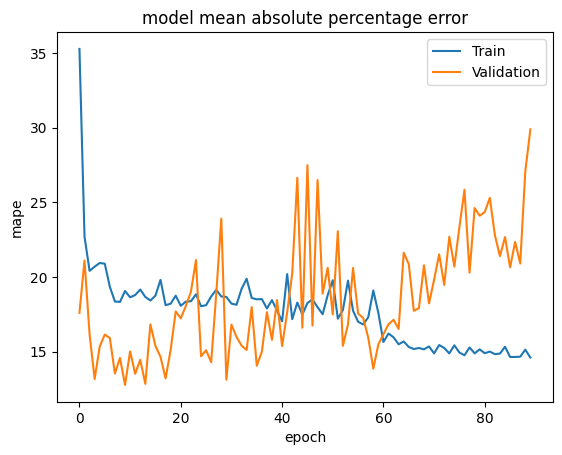

In [18]:
#Plot mape
plt.plot(model.history.history["mape"], label='Train')
plt.plot(model.history.history["val_mape"], label='Validation')
plt.legend()
plt.title('model mean absolute percentage error')
plt.ylabel('mape')
plt.xlabel('epoch')
#plt.ylim([35, 150])
#plt.xlim([0, 250])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

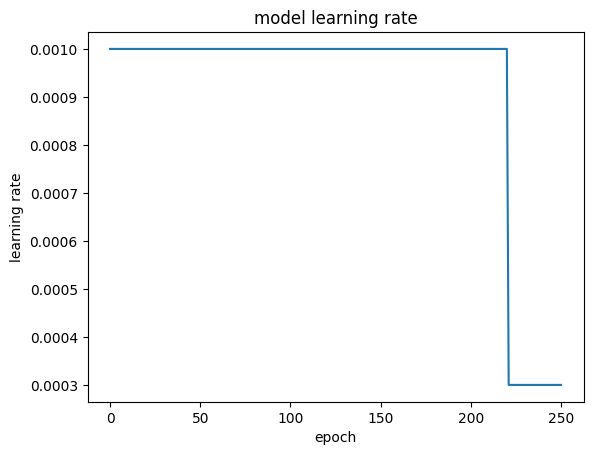

In [15]:
#Plot learning rate
plt.plot(model.history.history["lr"])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.show

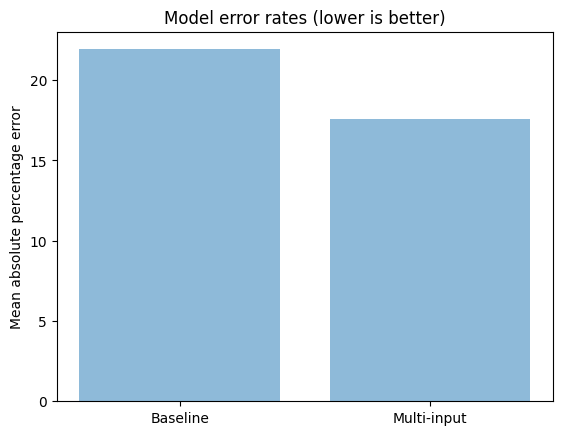

In [22]:
objects = ('Baseline', 'Multi-input')
y_pos = np.arange(len(objects))
performance = [21.92,17.57]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Mean absolute percentage error')
plt.title('Model error rates (lower is better)')

plt.show()